In [141]:
import numpy as np

def gamma_from_mean_cv(rng, mean, cv, size):
    k = 1.0 / (cv**2)
    theta = mean * (cv**2)
    return rng.gamma(k, theta, size=size)

def normal_from_mean_cv_pos(rng, mean, cv, size):
    sigma = mean * cv
    x = rng.normal(loc=mean, scale=sigma, size=size)
    bad = x <= 0
    while np.any(bad):
        x[bad] = rng.normal(loc=mean, scale=sigma, size=bad.sum())
        bad = x <= 0
    return x

def sample_connections(rng, masks, D, specs, no_autapse=True):
    N = next(iter(masks.values())).shape[0]
    C = np.zeros((N, N), dtype=bool)
    for key, rule in specs.items():
        m = masks[key]; n = m.sum()
        if not n: continue
        p_target = rule["p"]
        if rule["mode"] == "uniform":
            C[m] = rng.random(n) < p_target
        else:
            dsub = D[m]
            k = rule["c"] * np.exp(-dsub/rule["lam"])
            lo, hi = 0.0, 1e12
            for _ in range(40):
                mid = 0.5*(lo+hi)
                p_mid = 1.0 - np.exp(-mid*k)
                if p_mid.mean() < p_target: lo = mid
                else: hi = mid
            p_ij = 1.0 - np.exp(-hi*k)
            C[m] = rng.random(n) < p_ij
    if no_autapse:
        for k in ("E->E","I->I"):
            np.fill_diagonal(C, False)
    return C

class DelayedDoubleExpSynapses:
    """As before: double-exp PSP via two state filters + per-edge delays (ring buffer)."""
    def __init__(self, W, delays_ms, dt_ms, t_rise_ms=2.0, t_fall_ms=20.0, K=1.0, C=None):
        self.W = W if C is None else W * C
        self.dt = float(dt_ms); self.K = float(K)
        self.N_pre, self.N_post = self.W.shape
        self.alpha_r = np.exp(-self.dt / float(t_rise_ms))
        self.alpha_f = np.exp(-self.dt / float(t_fall_ms))
        d_samp = np.rint(delays_ms / self.dt).astype(int)
        if C is not None: d_samp = np.where(C, d_samp, 0)
        self.L = int(d_samp.max(initial=0)) + 1
        self.out_by_delay = []
        for j in range(self.N_pre):
            idx = np.where(self.W[j] != 0.0)[0]
            groups = {}
            if idx.size:
                dj = d_samp[j, idx]
                for k in np.unique(dj):
                    sel = (dj == k)
                    groups[int(k)] = (idx[sel], self.W[j, idx[sel]])
            self.out_by_delay.append(groups)
        self._inc_f = np.zeros((self.L, self.N_post))
        self._inc_r = np.zeros((self.L, self.N_post))
        self._p = 0
        self._gf = np.zeros(self.N_post)
        self._gr = np.zeros(self.N_post)

    def step(self, spikes_pre):
        spk_idx = np.nonzero(spikes_pre)[0]
        for j in spk_idx:
            s = float(spikes_pre[j]); 
            if s == 0: continue
            for k, (idx, wvals) in self.out_by_delay[j].items():
                slot = (self._p + k) % self.L
                self._inc_f[slot, idx] += s * wvals
                self._inc_r[slot, idx] += s * wvals
        self._gf = self.alpha_f * self._gf + self._inc_f[self._p]
        self._gr = self.alpha_r * self._gr + self._inc_r[self._p]
        U = self.K * (self._gf - self._gr)
        self._inc_f[self._p].fill(0.0); self._inc_r[self._p].fill(0.0)
        self._p = (self._p + 1) % self.L
        return U

    # In DelayedDoubleExpSynapses (add anywhere inside the class)
    def reset(self):
        self._inc_f.fill(0.0); self._inc_r.fill(0.0); self._p = 0
        self._gf.fill(0.0); self._gr.fill(0.0)
    
    def snapshot(self):
        return {
            "gf": self._gf.copy(), "gr": self._gr.copy(),
            "p": int(self._p),
            "inc_f": self._inc_f.copy(), "inc_r": self._inc_r.copy()
        }

    # add/replace in DelayedDoubleExpSynapses
    def refresh_rows(self, rows, W_abs):
        """
        Update absolute efficacies for given presynaptic rows from W_abs (N_pre x N_post).
        Supports either tuple layout: out_by_delay[j][k] == (idx_post, A)
        or dict layout: groups[j][k] == {"i": idx_post, "A": A}.
        """
        rows = np.atleast_1d(rows).astype(int)
        for j in rows:
            byk = getattr(self, "out_by_delay", None)
            if byk is None:
                byk = getattr(self, "groups", None)   # fallback name if you used 'groups'
            if byk is None:
                continue
    
            for k, item in byk[j].items():
                # tuple layout: (indices, A_array)
                if isinstance(item, tuple):
                    i, A = item
                    newA = W_abs[j, i]
                    A[...] = newA                     # mutate in place (tuple holds the array)
                    if hasattr(self, "W"):
                        self.W[j, i] = newA
                    # no need to reassign tuple; A mutated in place
                else:
                    # dict layout: {"i": indices, "A": A_array}
                    i, A = item["i"], item["A"]
                    newA = W_abs[j, i]
                    A[...] = newA
                    if hasattr(self, "W"):
                        self.W[j, i] = newA

    


In [142]:
class DelayedDoubleExpSynapsesSTP:
    """
    Double-exp synapse with Tsodyks–Markram UDF per synapse.
    Schedules amplitude A * (R_pre * u) at (t + delay).
    W: absolute efficacies (>=0); sign handled outside (e.g., minus for inhibitory path in u=y+z-h).
    """
    def __init__(self, W_abs, delays_ms, dt_ms, t_rise_ms, t_fall_ms, C_bool,
                 U_mat, D_mat, F_mat):
        self.dt = float(dt_ms)
        self.N_pre, self.N_post = W_abs.shape
        self.alpha_r = np.exp(-self.dt / t_rise_ms)
        self.alpha_f = np.exp(-self.dt / t_fall_ms)

        # integer delay (samples)
        d_samp = np.rint(delays_ms / self.dt).astype(int)
        self.L = int(d_samp.max(initial=0)) + 1

        # group outgoing synapses by presyn j and delay k
        self.groups = []
        for j in range(self.N_pre):
            idx = np.where(C_bool[j] & (W_abs[j] > 0.0))[0]
            byk = {}
            if idx.size:
                dj = d_samp[j, idx]
                for k in np.unique(dj):
                    sel = (dj == k)
                    byk[int(k)] = {
                        "i":   idx[sel],                # postsyn targets
                        "A":   W_abs[j, idx[sel]].copy(),
                        "U":   U_mat[j, idx[sel]].copy(),
                        "D":   D_mat[j, idx[sel]].copy(),
                        "F":   F_mat[j, idx[sel]].copy(),
                        # dynamic states per synapse:
                        "R":   np.ones(sel.sum(), float),          # availability (pre-spike)
                        "u":   U_mat[j, idx[sel]].copy(),          # utilization (effective at spike)
                    }
            self.groups.append(byk)

        # ring buffers for double-exp increments at postsynaptic side
        self._inc_f = np.zeros((self.L, self.N_post))
        self._inc_r = np.zeros((self.L, self.N_post))
        self._p = 0
        self._gf = np.zeros(self.N_post)
        self._gr = np.zeros(self.N_post)

        # last-spike step per presyn (for Δt); -inf means "never"
        self._last_step = np.full(self.N_pre, -10**12, dtype=int)

    def _schedule(self, k, idx, amp):
        slot = (self._p + k) % self.L
        self._inc_f[slot, idx] += amp
        self._inc_r[slot, idx] += amp

    def step(self, spikes_pre_row):
        # for each presynaptic spike, update UDF and schedule amplitudes
        spikers = np.nonzero(spikes_pre_row)[0]
        for j in spikers:
            s = int(spikes_pre_row[j])
            if s <= 0: continue
            dt_steps = max(0, self._p - self._last_step[j])  # valid because we advance _p by 1 each step
            self._last_step[j] = self._p
            Δt_ms = dt_steps * self.dt

            for k, G in self.groups[j].items():
                i   = G["i"];  A = G["A"];  U = G["U"];  D = G["D"];  F = G["F"]
                R   = G["R"];  u = G["u"]

                # between spikes: recover/decay
                eD = np.exp(-Δt_ms / np.maximum(D, 1e-12))
                # F=0 ⇒ exp(-Δt/F)=0  (makes u -> U at each spike)
                eF = np.where(F > 0.0, np.exp(-Δt_ms / F), 0.0)

                u = u * eF + U * (1.0 - u * eF)          # utilization at the spike
                R_pre = 1.0 - (1.0 - R) * eD             # available resources just before spike

                amp = s * A * (R_pre * u)                # event amplitude
                self._schedule(k, i, amp)

                R = R_pre * (1.0 - u)                    # deplete by u at the spike

                # write back
                G["R"], G["u"] = R, u

        # advance postsynaptic double-exp state one step
        out = self.alpha_f * self._gf + self._inc_f[self._p]
        self._gf = out
        out = self.alpha_r * self._gr + self._inc_r[self._p]
        self._gr = out
        U_post = (self._gf - self._gr)                   # K absorbed into A

        # clear slot and advance ring
        self._inc_f[self._p].fill(0.0); self._inc_r[self._p].fill(0.0)
        self._p = (self._p + 1) % self.L
        return U_post
        
    def reset(self):
        self._inc_f.fill(0.0); self._inc_r.fill(0.0); self._p = 0
        self._gf.fill(0.0); self._gr.fill(0.0)
    
    def snapshot(self):
        return {
            "gf": self._gf.copy(), "gr": self._gr.copy(),
            "p": int(self._p),
            "inc_f": self._inc_f.copy(), "inc_r": self._inc_r.copy()
        }

    # --- in DelayedDoubleExpSynapsesSTP (RECUR. STP engine) ---
# add/replace in DelayedDoubleExpSynapsesSTP
    def refresh_rows(self, rows, W_abs):
        """
        Update absolute efficacies for given presyn rows.
        Handles either dict layout (our STP engine: per-delay dict with "i","A",...)
        or tuple layout if you mirrored the static engine’s structure.
        """
        rows = np.atleast_1d(rows).astype(int)
        for j in rows:
            # STP engine usually uses self.groups[j] (dict of delays)
            byk = getattr(self, "groups", None)
            if byk is None:
                byk = getattr(self, "out_by_delay", None)
            if byk is None:
                continue
    
            for k, item in byk[j].items():
                if isinstance(item, dict):
                    i, A = item["i"], item["A"]
                    A[...] = W_abs[j, i]
                    if hasattr(self, "W"):
                        self.W[j, i] = W_abs[j, i]
                else:  # tuple layout
                    i, A = item
                    newA = W_abs[j, i]
                    A[...] = newA
                    if hasattr(self, "W"):
                        self.W[j, i] = newA


In [143]:
class SpikingNetwork:
    """
    Encapsulates: populations, 3D grid & distances, connectivity C, weights W, delays,
    and three pathway-specific PSP engines (inputs, excitatory, inhibitory).
    Step() returns y, z, h, u, r for all postsyn neurons.
    """
    def __init__(self,
                 N_inp=200, N_exc=432, N_inh=108,
                 dt_ms=1.0, t_rise_ms=2.0, t_fall_ms=20.0, K=1.0,
                 rng=None, spacing=(1.0,1.0,1.0), randomize_grid=True,
                 conn_specs=None, weight_specs=None, delay_specs=None):
        self.rng = np.random.default_rng() if rng is None else rng
        self.N_inp, self.N_exc, self.N_inh = N_inp, N_exc, N_inh
        self.N = N_inp + N_exc + N_inh
        self.dt = float(dt_ms)
        self.r0 = 1.238  # Hz
        self.alpha = 0.25          # slope in r = r0 * exp(alpha * u)
        self.r_cap = 200.0         # hard cap on instantaneous rate [Hz]; tune as needed (> r0)
        self.t_rise_ms = t_rise_ms
        self.t_fall_ms = t_fall_ms
        
        # populations
        self.types = np.r_[np.zeros(N_inp,int), np.ones(N_exc,int), np.full(N_inh,2,int)]
        self.is_inp = (self.types==0); self.is_exc = (self.types==1); self.is_inh = (self.types==2)

        # masks (pre rows, post cols)
        self.masks = {
            "E->E":   self.is_exc[:,None] & self.is_exc[None,:],
            "E->I":   self.is_exc[:,None] & self.is_inh[None,:],
            "I->E":   self.is_inh[:,None] & self.is_exc[None,:],
            "I->I":   self.is_inh[:,None] & self.is_inh[None,:],
            "inp->E": self.is_inp[:,None] & self.is_exc[None,:],
        }
        for k in ("E->E","I->I"):
            np.fill_diagonal(self.masks[k], False)

        # 3D grid for network neurons (E+I): 6x6x15
        gx, gy, gz = 6, 6, 15
        assert gx*gy*gz == (N_exc+N_inh)
        grid = np.stack(np.meshgrid(np.arange(gx), np.arange(gy), np.arange(gz), indexing='ij'),
                        axis=-1).reshape(-1,3).astype(float)
        grid -= grid.mean(axis=0)
        grid *= np.array(spacing, float)
        if randomize_grid:
            grid = grid[self.rng.permutation(grid.shape[0])]
        self.pos = np.zeros((self.N,3), float)
        self.pos[self.is_exc] = grid[:N_exc]
        self.pos[self.is_inh] = grid[N_exc:]
        idx_net = np.where(~self.is_inp)[0]
        P = self.pos[idx_net]
        D_net = np.sqrt(((P[:,None,:]-P[None,:,:])**2).sum(axis=2))
        self.D = np.zeros((self.N,self.N), float)
        self.D[np.ix_(idx_net, idx_net)] = D_net

        # default specs (can be overridden)
        self.conn_specs = conn_specs or {
            "inp->E": {"p": 0.50, "mode": "uniform"},
            "E->E":   {"p": 0.50, "mode": "uniform"},
            "E->I":   {"p": 0.04, "mode": "distance", "c": 2e5, "lam": 0.25},
            "I->E":   {"p": 0.05, "mode": "distance", "c": 4e5, "lam": 0.25},
            "I->I":   {"p": 0.04, "mode": "distance", "c": 1e5, "lam": 0.25},
        }
        self.weight_specs = weight_specs or {
            "E->E":   (2.5,   0.7,  +1),
            "E->I":   (1000., 0.7,  +1),
            "I->E":   (1375., 0.7,  -1),
            "I->I":   (6000., 0.7,  -1),
            "inp->E": (15.,   0.07, +1),
        }
        self.delay_specs = delay_specs or {
            "E->E":   (5.0, 0.5),
            "E->I":   (5.0, 0.5),
            "I->E":   (2.0, 0.5),
            "I->I":   (2.0, 0.5),
            "inp->E": (2.0, 0.5),
        }

        # connectivity
        self.C = sample_connections(self.rng, self.masks, self.D, self.conn_specs, no_autapse=True)

        # weights and delays (full N x N)
        self.W = np.zeros((self.N,self.N), float)
        self.delays = np.zeros((self.N,self.N), float)
        for key, (mean, cv, sign) in self.weight_specs.items():
            m = self.masks[key] & self.C
            n = int(m.sum())
            if n: self.W[m] = sign * gamma_from_mean_cv(self.rng, mean, cv, size=n)
        for key, (mean, cv) in self.delay_specs.items():
            m = self.masks[key] & self.C
            n = int(m.sum())
            if n: self.delays[m] = normal_from_mean_cv_pos(self.rng, mean, cv, size=n)


        # ---- STP specs (mean ± SD) ----
        self.stp_specs = {
            "E->E": (0.45, 0.17, 144.0,  67.0,   0.0,   0.0),
            "E->I": (0.09, 0.12, 138.0, 211.0, 670.0, 830.0),
            "I->E": (0.16, 0.10,  45.0,  21.0, 376.0, 253.0),
            "I->I": (0.25, 0.13, 706.0, 405.0,  21.0,   9.0),
        }
        self.U_mat = np.zeros_like(self.W, float)
        self.D_mat = np.zeros_like(self.W, float)
        self.F_mat = np.zeros_like(self.W, float)

        def _clipUDF(U, D, F):
            return (np.clip(U, 0.001, 0.999),
                    np.clip(D, 0.1, 5000.0),
                    np.clip(F, 0.0, 5000.0))

        for key, (Um,Usd, Dm,Dsd, Fm,Fsd) in self.stp_specs.items():
            m = self.masks[key] & self.C
            n = int(m.sum())
            if n == 0: continue
            U = self.rng.normal(Um, Usd, size=n)
            D = self.rng.normal(Dm, Dsd, size=n)
            F = self.rng.normal(Fm, Fsd, size=n)
            U,D,F = _clipUDF(U,D,F)
            self.U_mat[m], self.D_mat[m], self.F_mat[m] = U, D, F

        # ---- [STP #2] Steady-state weight correction at f0=5 Hz ----
        def _steady_state_uR(U, D, F, r_hz):
            """
            Safe steady-state u*, R* for TM synapse at constant presyn rate r_hz.
            Handles scalar or array inputs and F=0 (pure depression) without division by zero.
            U in [0,1], D,F in ms.
            """
            U = np.asarray(U, dtype=float)
            D = np.asarray(D, dtype=float)
            F = np.asarray(F, dtype=float)
        
            ISI = 1000.0 / max(r_hz, 1e-9)                    # ms
            eD  = np.exp(-ISI / np.maximum(D, 1e-12))         # recovery
        
            eF  = np.zeros_like(F, dtype=float)               # facilitation
            mask = F > 0.0
            if np.any(mask):
                eF[mask] = np.exp(-ISI / F[mask])             # only compute where F>0
        
            u_star = U / (1.0 - (1.0 - U) * eF)
            u_star = np.clip(u_star, 1e-6, 1.0 - 1e-6)
            R_star = (1.0 - eD) / (1.0 - (1.0 - u_star) * eD)
            R_star = np.clip(R_star, 1e-6, 1.0)
        
            # return scalars instead of 0-d arrays when inputs were scalars
            u_star = float(u_star) if u_star.shape == () else u_star
            R_star = float(R_star) if R_star.shape == () else R_star
            return u_star, R_star

        f0 = 5.0
        m_stp = (self.U_mat > 0)
        if np.any(m_stp):
            u_ss, R_ss = _steady_state_uR(self.U_mat[m_stp], self.D_mat[m_stp], self.F_mat[m_stp], f0)
            A = np.abs(self.W[m_stp])
            A /= (R_ss * u_ss + 1e-12)
            self.W[m_stp] = np.sign(self.W[m_stp]) * A

        # ---- [STP #4] Engines: static inp->E; STP on E/I ----
        t_r = self.t_rise_ms; t_f = self.t_fall_ms
        Wabs = np.abs(self.W)
        W_inp = np.where(self.is_inp[:,None], Wabs, 0.0)
        W_exc = np.where(self.is_exc[:,None], Wabs, 0.0)
        W_inh = np.where(self.is_inh[:,None], Wabs, 0.0)

        self._syn_inp = DelayedDoubleExpSynapses(W_inp, self.delays, self.dt, t_r, t_f, K=1.0, C=self.C)
        self._syn_exc = DelayedDoubleExpSynapsesSTP(W_exc, self.delays, self.dt, t_r, t_f, self.C,
                                                    self.U_mat, self.D_mat, self.F_mat)
        self._syn_inh = DelayedDoubleExpSynapsesSTP(W_inh, self.delays, self.dt, t_r, t_f, self.C,
                                                    self.U_mat, self.D_mat, self.F_mat)

        self.stdp_paths = ("inp->E", "E->E")
        self.stdp_mask = np.zeros_like(self.W, dtype=bool)
        for k in self.stdp_paths:
            self.stdp_mask |= (self.masks[k] & self.C)
        
        # Triplet detectors: presyn r1,r2; postsyn o1,o2
        self.r1 = np.zeros(self.N, float)
        self.r2 = np.zeros(self.N, float)
        self.o1 = np.zeros(self.N, float)
        self.o2 = np.zeros(self.N, float)
        
        # Time constants (ms) and per-step decays
        self.tau_r1 = 25.0;  self.tau_r2 = 25.0
        self.tau_o1 = 1000.0; self.tau_o2 = 25.0
        self.dec_r1 = np.exp(-self.dt / self.tau_r1)
        self.dec_r2 = np.exp(-self.dt / self.tau_r2)
        self.dec_o1 = np.exp(-self.dt / self.tau_o1)
        self.dec_o2 = np.exp(-self.dt / self.tau_o2)
        
        # Amplitudes (Eq. 19)
        self.A2p = 10.0; self.A3p = 10.0
        self.A2m = 0.5;  self.A3m = 0.5
        
        # Learning rate & bounds for multiplicative rule
        self.eta = 1e-3              # tune (1e-4 .. 1e-2 depending on dt and desired speed)
        # Caps per pathway (multiplicative: LTP ∝ (w_max - w)/w_max, LTD ∝ w/w_max)
        self.wcap = np.full_like(self.W, np.inf, float)
        for k in self.stdp_paths:
            m = self.masks[k] & self.C
            if np.any(m):
                # per-pathway cap = 3× 99th percentile of initial weights (positive)
                base = np.percentile(self.W[m], 99)
                self.wcap[m] = max(1e-12, 3.0 * base)
        
        # Convenience boolean index of plastic presynaptic rows for fast refresh
        self._stdp_rows_inp = np.where(self.is_inp)[0]   # subset will be used per step
        self._stdp_rows_exc = np.where(self.is_exc)[0]
        
        
        self.r0 = 1.238  # Hz

        self.gamma_exc = 1.0  # can be user-set; γ_exc in paper
        mu_ln, sigma_ln = 2.64, 0.23

        # individual components (shifted by -600)
        self.E_ind_exc = np.zeros(self.N)
        self.E_ind_exc[self.is_exc] = self.rng.lognormal(mean=mu_ln, sigma=sigma_ln, size=self.is_exc.sum()) - 600.0
        
        self.I_ind_inh = np.zeros(self.N)
        self.I_ind_inh[self.is_inh] = self.rng.lognormal(mean=mu_ln, sigma=sigma_ln, size=self.is_inh.sum()) - 600.0
        
        # generic components
        self.E_generic_exc = 300.0 * self.gamma_exc   # for excitatory population
        self.I_generic_inh = 450.0                    # for inhibitory population
        
        # --- Refractory state (NEW) ---
        self.ref_remaining = np.zeros(self.N, dtype=int)  # steps remaining in refractory
        self.ref_mean_ms_exc = 10.0
        self.ref_mean_ms_inh = 3.0
        self.ref_shape_k = 2.0  # Gamma shape

        
    @property
    def engines(self):
        return {"inp": self._syn_inp, "exc": self._syn_exc, "inh": self._syn_inh}
    
    def reset_state(self):
        for e in self.engines.values():
            e.reset()

    def step(self, spikes):
        y = self._syn_inp.step(spikes)   # input PSP sum
        z = self._syn_exc.step(spikes)   # excitatory PSP sum
        h = self._syn_inh.step(spikes)   # inhibitory PSP sum

                # population-specific excitability bias
        bias = np.zeros(self.N, dtype=float)
        bias[self.is_exc] = self.E_ind_exc[self.is_exc] + self.E_generic_exc
        bias[self.is_inh] = self.I_ind_inh[self.is_inh] + self.I_generic_inh
        
        u = y + z - h + bias    
        if hasattr(self, "stdp_mask"):          # or a boolean self.enable_stdp
            self.apply_stdp(spikes)

        
        phi = np.clip(self.alpha * u, -50.0, np.log(self.r_cap / self.r0))
        r = self.r0 * np.exp(phi)          # numerically safe
        return {"y": y, "z": z, "h": h, "u": u, "r": r}

    def poisson_spike_step(self, rates_hz):
        lam = rates_hz * (self._syn_inp.dt / 1000.0)
        return self.rng.poisson(lam)

    def _draw_refractory_steps(self, idx_mask):
        """Draw Gamma(k=2) refractory durations in *steps* for given boolean mask of neurons."""
        if not np.any(idx_mask):
            return np.zeros(0, dtype=int)
        # means (ms) per neuron
        means = np.zeros(idx_mask.sum(), float)
        means[np.where(self.is_exc[idx_mask])[0]] = self.ref_mean_ms_exc
        means[np.where(self.is_inh[idx_mask])[0]] = self.ref_mean_ms_inh
        # Gamma: mean = k*theta  =>  theta = mean/k
        theta = means / self.ref_shape_k
        # independent draws
        steps = np.ceil(self.rng.gamma(shape=self.ref_shape_k, scale=theta) / self.dt).astype(int)
        steps[steps < 1] = 1
        return steps

    def apply_refractory_and_update(self, spikes):
        """
        Enforce absolute refractory on E/I neurons:
          - zero spikes where refractory is active
          - start new refractory where spikes occurred
          - decrement existing refractory counters
        Returns modified spikes (0/1 for E/I) and updates self.ref_remaining.
        """
        spikes = spikes.copy()
    
        # decrement existing
        self.ref_remaining = np.maximum(self.ref_remaining - 1, 0)
    
        # block firing during refractory (E/I only)
        ei = (self.is_exc | self.is_inh)
        active_ref = (self.ref_remaining > 0) & ei
        spikes[active_ref] = 0
        spikes[ei] = (spikes[ei] > 0).astype(int)  # at most 1 per bin during absolute refractory model
    
        # start refractory for newly spiking E/I neurons
        fired = (spikes > 0) & ei
        if np.any(fired):
            steps = self._draw_refractory_steps(fired)
            self.ref_remaining[fired] = steps
    
        return spikes

    def sample_recurrent_spikes(self, rates_prev_hz):
        """
        Generate E/I spikes from instantaneous rates (Hz) from previous step, with refractory.
        Inputs remain 0 here (external drive handled by caller).
        """
        spikes = np.zeros(self.N, dtype=int)
        lam = np.clip(rates_prev_hz, 0.0, np.inf) * (self.dt / 1000.0)
        spikes[self.is_exc | self.is_inh] = self.rng.poisson(lam[self.is_exc | self.is_inh])
        return self.apply_refractory_and_update(spikes)

    def apply_stdp(self, spikes):
        """
        Triplet STDP (Eq. 19) for plastic synapses (inp->E and E->E).
        Order per time step:
          1) decay detectors,
          2) apply weight updates at this step using r1,r2,o1,o2 at t^-  (epsilon),
          3) increment detectors by current spikes,
          4) refresh engine weights for changed rows.
        """
        # 1) decay
        self.r1 *= self.dec_r1; self.r2 *= self.dec_r2
        self.o1 *= self.dec_o1; self.o2 *= self.dec_o2
    
        # presyn and postsyn spike lists
        s = spikes.astype(int)
        pre_inp = np.where(self.is_inp & (s > 0))[0]
        pre_exc = np.where(self.is_exc & (s > 0))[0]
        post_exc = np.where(self.is_exc & (s > 0))[0]   # posts for both inp->E and E->E
    
        rows_to_refresh_inp = set()
        rows_to_refresh_exc = set()
    
        # --- PRE events (LTD): for each presyn j, update all plastic j->i edges using o1[i], r2[j]
        # LTD Δw = -η * o1_i * (A2m + A3m * r2_j) * (w / wcap)
        for j in np.concatenate([pre_inp, pre_exc]):
            s_j = s[j]
            # plastic outgoing targets from j
            m_row = self.stdp_mask[j]
            if not np.any(m_row): 
                continue
            i_idx = np.where(m_row)[0]
            # only posts that are excitatory (by definition of the two pathways)
            # (m_row already enforces that)
            w = self.W[j, i_idx]
            cap = self.wcap[j, i_idx]
            g_ltd = self.o1[i_idx] * (self.A2m + self.A3m * self.r2[j])
            dw = - self.eta * s_j * g_ltd * (w / np.maximum(cap, 1e-12))
            self.W[j, i_idx] = np.clip(w + dw, 0.0, cap)   # keep non-negative, not above cap
            # mark row for engine refresh
            if self.is_inp[j]: rows_to_refresh_inp.add(int(j))
            if self.is_exc[j]: rows_to_refresh_exc.add(int(j))
    
        # --- POST events (LTP): for each postsyn i (excitatory), update all plastic j->i edges using r1[j], o2[i]
        # LTP Δw = +η * r1_j * (A2p + A3p * o2_i) * ((wcap - w)/wcap)
        for i in post_exc:
            s_i = s[i]
            m_col = self.stdp_mask[:, i]
            if not np.any(m_col): 
                continue
            j_idx = np.where(m_col)[0]   # inputs + exc presyn
            w = self.W[j_idx, i]
            cap = self.wcap[j_idx, i]
            g_ltp = self.r1[j_idx] * (self.A2p + self.A3p * self.o2[i])
            dw = + self.eta * s_i * g_ltp * ((cap - w) / np.maximum(cap, 1e-12))
            self.W[j_idx, i] = np.clip(w + dw, 0.0, cap)
            # mark rows for refresh (engines are organized by presyn rows)
            rows_to_refresh_inp.update(j for j in j_idx if self.is_inp[j])
            rows_to_refresh_exc.update(j for j in j_idx if self.is_exc[j])
    
        # 3) increment detectors (epsilon: do this AFTER using r2/o2)
        self.r1[pre_inp] += s[pre_inp]; self.r1[pre_exc] += s[pre_exc]
        self.r2[pre_inp] += s[pre_inp]; self.r2[pre_exc] += s[pre_exc]
        self.o1[post_exc] += s[post_exc]; self.o2[post_exc] += s[post_exc]
    
        # 4) push updated |W| into engines so future spikes use new efficacies
        if rows_to_refresh_inp:
            Wabs = np.abs(self.W)
            self._syn_inp.refresh_rows(np.fromiter(rows_to_refresh_inp, int), Wabs)
        if rows_to_refresh_exc:
            Wabs = np.abs(self.W)
            self._syn_exc.refresh_rows(np.fromiter(rows_to_refresh_exc, int), Wabs)


In [144]:
# Run a short noise-only sim and check that E->E and inp->E weights actually move.
import numpy as np

def probe_stdp_weight_drift(net, T_ms=2000, bg_rate_hz=5.0, seed=0):
    rng = np.random.default_rng(seed)
    dt = net.dt; T = int(round(T_ms/dt))
    lam_inp = bg_rate_hz * (dt/1000.0)

    # snapshot initial weights for plastic paths
    m_plastic = net.stdp_mask
    W0 = net.W.copy()

    net.reset_state()
    rates_prev = np.zeros(net.N); rates_prev[net.is_exc|net.is_inh] = net.r0
    for t in range(T):
        spikes = np.zeros(net.N, int)
        spikes[net.is_inp] = rng.poisson(lam_inp, size=net.is_inp.sum())
        lam_ei = rates_prev[net.is_exc|net.is_inh]*(dt/1000.0)
        spikes[net.is_exc|net.is_inh] = rng.poisson(np.clip(lam_ei,0,None))
        spikes = net.apply_refractory_and_update(spikes)
        out = net.step(spikes)
        rates_prev[:] = 0.0; rates_prev[net.is_exc|net.is_inh] = out["r"][net.is_exc|net.is_inh]

    dW = net.W[m_plastic] - W0[m_plastic]
    print(f"Δw stats over {T_ms} ms (plastic edges only): "
          f"median {np.median(dW):.4f}, mean {np.mean(dW):.4f}, "
          f"+% {(dW>0).mean()*100:.1f}%, -% {(dW<0).mean()*100:.1f}%")

# Example:
net = SpikingNetwork(N_inp=200, N_exc=432, N_inh=108, dt_ms=1.0, rng=np.random.default_rng(1))
probe_stdp_weight_drift(net, T_ms=2000, bg_rate_hz=5.0, seed=1)


Δw stats over 2000 ms (plastic edges only): median 0.0000, mean -0.1348, +% 0.3%, -% 0.1%


C:\Users\miles\AppData\Local\Temp\ipykernel_23960\2020231938.py:71: RuntimeWarning: divide by zero encountered in divide
  eF = np.where(F > 0.0, np.exp(-Δt_ms / F), 0.0)
C:\Users\miles\AppData\Local\Temp\ipykernel_23960\2020231938.py:71: RuntimeWarning: invalid value encountered in divide
  eF = np.where(F > 0.0, np.exp(-Δt_ms / F), 0.0)


In [146]:
# ===================== STDP unit tests (copy–paste and run) =====================
import numpy as np

# ---- helpers -----------------------------------------------------------------
def pick_plastic_edge(net, prefer="inp->E"):
    """Return (j,i,path_key) for a plastic synapse. Prefer inp->E then E->E."""
    paths = [prefer, "E->E"] if prefer != "E->E" else ["E->E"]
    for k in paths:
        m = (net.masks[k] & net.C)
        if np.any(m):
            jj, ii = np.nonzero(m)
            return int(jj[0]), int(ii[0]), k
    raise RuntimeError("No plastic synapse found.")

def schedule_pairs(T_steps, dt_ms, delta_t_ms, n_pairs=10, f_pair_hz=20.0):
    """
    Build a boolean array 'has_pre', 'has_post' of length T_steps with pre/post events
    for a single synapse, separated by Δt=delta_t_ms (pre -> post if Δt>0).
    """
    period = int(round(1000.0 / f_pair_hz / dt_ms))  # steps
    k = int(round(delta_t_ms / dt_ms))
    has_pre = np.zeros(T_steps, dtype=bool)
    has_post = np.zeros(T_steps, dtype=bool)
    # choose times so both pre & post are within [0, T_steps)
    offset = max(0, -k)   # shift so that for Δt<0, post happens before pre but >=0
    for n in range(n_pairs):
        t_pre = offset + n * period
        t_post = t_pre + k
        if 0 <= t_pre < T_steps:  has_pre[t_pre] = True
        if 0 <= t_post < T_steps: has_post[t_post] = True
    return has_pre, has_post

def apply_protocol_only_stdp(net, j, i, has_pre, has_post):
    """Run STDP only (no PSP stepping), applying net.apply_stdp at each step."""
    # snapshot & reset detectors
    W0 = net.W[j, i].copy()
    net.r1.fill(0.0); net.r2.fill(0.0); net.o1.fill(0.0); net.o2.fill(0.0)
    # walk through time
    for t in range(len(has_pre)):
        spikes = np.zeros(net.N, dtype=int)
        if has_pre[t]:  spikes[j] = 1
        if has_post[t]: spikes[i] = 1
        net.apply_stdp(spikes)
    return net.W[j, i] - W0  # Δw

def get_engine_amplitude_for_edge(net, j, i):
    """Return the engine's stored absolute amplitude for edge j->i (first match)."""
    eng = net._syn_inp if net.is_inp[j] else net._syn_exc
    byk = getattr(eng, "out_by_delay", None)
    if byk is None:
        byk = getattr(eng, "groups", None)
    if byk is None:
        return None
    # iterate all delays for row j and pick the entry that contains i
    for k, item in byk[j].items():
        if isinstance(item, tuple):
            idx_post, A = item
        else:
            idx_post, A = item["i"], item["A"]
        where = np.where(idx_post == i)[0]
        if where.size:
            return float(A[where[0]])
    return None

# ---- tests -------------------------------------------------------------------
def test_pairing_sign_and_shape(net, n_pairs=1, f_hz=20.0):
    """
    Validate the canonical STDP sign with an *isolated* pair (n_pairs=1).
    For repeated pairs (n_pairs>1) at 20 Hz, triplet interactions can flip Δt<0 to net LTP.
    """
    W_backup = net.W.copy()
    j,i,_ = pick_plastic_edge(net, prefer="inp->E")
    T_steps = int((1.2 * (1000.0/f_hz) + 60.0) / net.dt)  # enough room for both spikes

    for dt_small, dt_large in [(+10, +40), (-10, -40)]:
        # single pair, small |Δt|
        has_pre, has_post = schedule_pairs(T_steps, net.dt, dt_small, n_pairs=1, f_pair_hz=f_hz)
        dw_small = apply_protocol_only_stdp(net, j, i, has_pre, has_post)

        # single pair, larger |Δt|
        has_pre, has_post = schedule_pairs(T_steps, net.dt, dt_large, n_pairs=1, f_pair_hz=f_hz)
        dw_large = apply_protocol_only_stdp(net, j, i, has_pre, has_post)

        if dt_small > 0:
            assert dw_small > 0, f"LTP expected for Δt={dt_small}ms, got {dw_small}"
            assert abs(dw_small) > abs(dw_large) + 1e-12, "LTP should decay with |Δt|"
        else:
            assert dw_small < 0, f"LTD expected for Δt={dt_small}ms, got {dw_small}"
            assert abs(dw_small) > abs(dw_large) + 1e-12, "LTD should decay with |Δt|"

    net.W[:] = W_backup
    print("OK: pairing sign and decay with |Δt| (single isolated pair)")


def test_no_update_without_both_spikers(net, n_pairs=10, f_hz=20.0):
    W_backup = net.W.copy()
    j,i,_ = pick_plastic_edge(net, prefer="inp->E")
    T_steps = int( (n_pairs * (1000.0/f_hz) + 10) / net.dt )

    has_pre, has_post = schedule_pairs(T_steps, net.dt, 0.0, n_pairs, f_hz)
    # pre-only
    dw = apply_protocol_only_stdp(net, j, i, has_pre, np.zeros_like(has_post))
    assert abs(dw) < 1e-12, f"Pre-only should not change w, got Δw={dw}"
    # post-only
    dw = apply_protocol_only_stdp(net, j, i, np.zeros_like(has_pre), has_post)
    assert abs(dw) < 1e-12, f"Post-only should not change w, got Δw={dw}"

    net.W[:] = W_backup
    print("OK: no change with pre-only and post-only")

def test_caps_and_nonnegativity(net):
    W_backup = net.W.copy()
    j,i,_ = pick_plastic_edge(net, prefer="inp->E")
    cap = float(net.wcap[j, i]) if np.isfinite(net.wcap[j, i]) else np.inf

    # drive strong LTP toward cap (many pairs with small positive Δt)
    n_pairs = 400
    T_steps = int( (n_pairs * 50.0 + 20.0) / net.dt )  # 20 Hz -> 50ms
    has_pre, has_post = schedule_pairs(T_steps, net.dt, +10.0, n_pairs, 20.0)
    _ = apply_protocol_only_stdp(net, j, i, has_pre, has_post)
    w = float(net.W[j, i])

    assert w >= 0.0, "Weight went negative!"
    if np.isfinite(cap):
        assert w <= cap + 1e-9, f"Weight exceeded cap: w={w}, cap={cap}"
        # Push further; should remain at cap
        _ = apply_protocol_only_stdp(net, j, i, has_pre, has_post)
        w2 = float(net.W[j, i])
        assert abs(w2 - min(cap, w2)) < 1e-9, "Weight should saturate at cap"
    net.W[:] = W_backup
    print("OK: caps enforced and weights remain non-negative")

def test_engine_refresh_after_update(net):
    W_backup = net.W.copy()
    j,i,path = pick_plastic_edge(net, prefer="inp->E")

    # do a small LTP update
    has_pre, has_post = schedule_pairs(T_steps=200, dt_ms=net.dt, delta_t_ms=+10.0, n_pairs=2, f_pair_hz=20.0)
    _ = apply_protocol_only_stdp(net, j, i, has_pre, has_post)
    w_abs = abs(float(net.W[j, i]))
    a = get_engine_amplitude_for_edge(net, j, i)
    assert a is not None, "Could not find engine amplitude for edge"
    # allow tiny FP mismatch
    assert abs(a - w_abs) <= 1e-9, f"Engine amplitude not refreshed: engine={a}, W={w_abs}"

    net.W[:] = W_backup
    print("OK: engine weight refresh after STDP update")

def test_eta_scaling_small_signal(net):
    """Small-signal regime: Δw should scale ~linearly with eta."""
    W_backup = net.W.copy()
    eta0 = net.eta
    j,i,_ = pick_plastic_edge(net, prefer="inp->E")
    has_pre, has_post = schedule_pairs(T_steps=200, dt_ms=net.dt, delta_t_ms=+10.0, n_pairs=1, f_pair_hz=20.0)

    net.eta = eta0
    dw1 = apply_protocol_only_stdp(net, j, i, has_pre, has_post)
    net.W[:] = W_backup; net.r1.fill(0); net.r2.fill(0); net.o1.fill(0); net.o2.fill(0)

    net.eta = eta0 * 2.0
    dw2 = apply_protocol_only_stdp(net, j, i, has_pre, has_post)

    # back to original
    net.eta = eta0; net.W[:] = W_backup
    ratio = (dw2 / (dw1 + 1e-18))
    assert 1.6 <= ratio <= 2.4, f"Expected ~2x scaling with eta; got {ratio:.2f}"
    print("OK: small-signal Δw scales ~linearly with eta")

# ---- run all ---------------------------------------------------------------
def run_all_stdp_tests(net):
    test_pairing_sign_and_shape(net)
    test_no_update_without_both_spikers(net)
    test_caps_and_nonnegativity(net)
    test_engine_refresh_after_update(net)
    test_eta_scaling_small_signal(net)
    print("All STDP tests passed ✅")

def demo_triplet_cross_pair_interaction(net):
    """Show that 10 pairs @20 Hz can yield net LTP even for Δt<0 due to residual pre-traces."""
    W_backup = net.W.copy()
    j,i,_ = pick_plastic_edge(net, prefer="inp->E")
    T_steps = int( (10 * 50.0 + 60.0) / net.dt )  # 10 pairs at 20 Hz
    has_pre, has_post = schedule_pairs(T_steps, net.dt, -10.0, n_pairs=10, f_pair_hz=20.0)
    dw = apply_protocol_only_stdp(net, j, i, has_pre, has_post)
    net.W[:] = W_backup
    print(f"Δw for 10 pairs, Δt=-10 ms @20 Hz (triplet): {dw:+.6f}  (can be >0)")

# Example usage (assumes 'net' is your SpikingNetwork with STDP integrated):
run_all_stdp_tests(net)
demo_triplet_cross_pair_interaction(net)


OK: pairing sign and decay with |Δt| (single isolated pair)
OK: no change with pre-only and post-only
OK: caps enforced and weights remain non-negative
OK: engine weight refresh after STDP update
OK: small-signal Δw scales ~linearly with eta
All STDP tests passed ✅
Δw for 10 pairs, Δt=-10 ms @20 Hz (triplet): +0.009387  (can be >0)


C:\Users\miles\AppData\Local\Temp\ipykernel_23960\2020231938.py:71: RuntimeWarning: invalid value encountered in divide
  eF = np.where(F > 0.0, np.exp(-Δt_ms / F), 0.0)
C:\Users\miles\AppData\Local\Temp\ipykernel_23960\2020231938.py:71: RuntimeWarning: divide by zero encountered in divide
  eF = np.where(F > 0.0, np.exp(-Δt_ms / F), 0.0)
C:\Users\miles\AppData\Local\Temp\ipykernel_23960\466619333.py:241: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0,0,1,0.96])


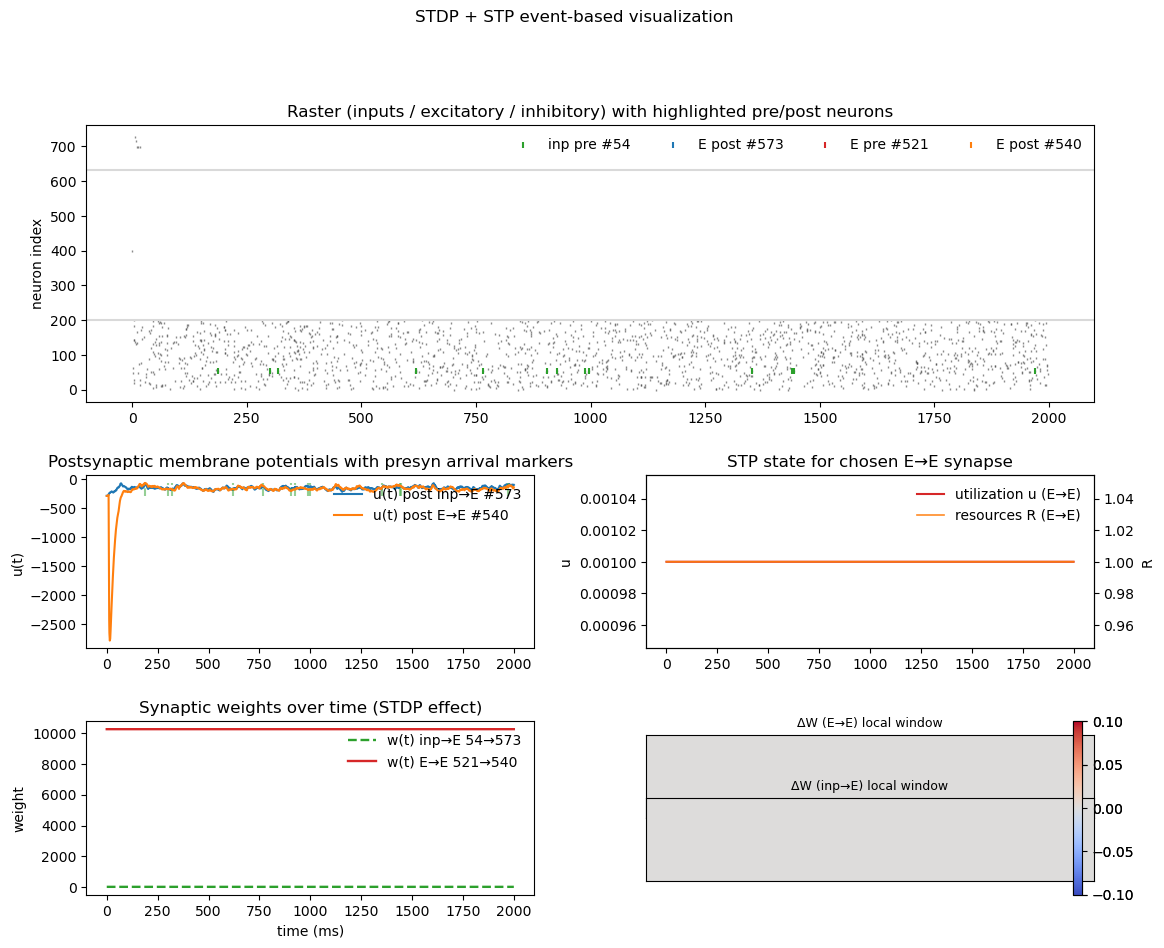

In [148]:
# ===================== STDP + STP "event view" (3×2 dashboard) =====================
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

def _pick_plastic_edge(net, key):
    m = (net.masks[key] & net.C & net.stdp_mask)
    if not np.any(m):
        return None
    jj, ii = np.nonzero(m)
    # pick the strongest magnitude to get a visible signal
    wabs = np.abs(net.W[m])
    k = int(np.argmax(wabs))
    return int(jj[k]), int(ii[k])

def _engine_find_entry(eng, j, i):
    """Return a tuple (A, R, u) array-views for presyn row j -> postsyn i if present; else (None, None, None).
       Works for both tuple layout (idx, A) and dict layout {"i", "A", "R", "u"}."""
    byk = getattr(eng, "groups", None)
    if byk is None:
        byk = getattr(eng, "out_by_delay", None)
    if byk is None or j >= len(byk):
        return (None, None, None)
    for k, item in byk[j].items():
        if isinstance(item, tuple):
            idx_post, A = item
            where = np.where(idx_post == i)[0]
            if where.size:
                # no STP state here (static engine)
                return (A[where[0]:where[0]+1], None, None)
        else:
            idx_post, A = item["i"], item["A"]
            where = np.where(idx_post == i)[0]
            if where.size:
                R = item.get("R", None)
                u = item.get("u", None)
                Rv = R[where[0]:where[0]+1] if R is not None else None
                uv = u[where[0]:where[0]+1] if u is not None else None
                return (A[where[0]:where[0]+1], Rv, uv)
    return (None, None, None)

def visualize_plasticity_event_dashboard(net, duration_ms=2000, bg_rate_hz=5.0,
                                         r_cap=200.0, seed=1, window_half=25,
                                         restore_weights=False):
    rng = np.random.default_rng(seed)
    dt = float(net.dt)
    T  = int(round(duration_ms / dt))
    N  = net.N
    EI = (net.is_exc | net.is_inh)

    # ---- choose two plastic synapses: one inp->E, one E->E
    sel_inp = _pick_plastic_edge(net, "inp->E")
    sel_ee  = _pick_plastic_edge(net, "E->E")
    if sel_inp is None and sel_ee is None:
        raise RuntimeError("No plastic synapses (inp->E or E->E) found.")
    if sel_inp is not None:
        j_inp, i_inp = sel_inp
    if sel_ee is not None:
        j_ee,  i_ee  = sel_ee

    # initial snapshots for ΔW maps
    W0 = net.W.copy()

    # allocate logs
    S = np.zeros((N, T), dtype=int)
    u_post_inp = np.zeros(T) if sel_inp else None
    u_post_ee  = np.zeros(T) if sel_ee  else None
    w_t_inp = np.zeros(T) if sel_inp else None
    w_t_ee  = np.zeros(T) if sel_ee  else None
    R_t_ee  = np.zeros(T) if sel_ee  else None
    u_t_ee  = np.zeros(T) if sel_ee  else None

    # precompute delay steps for arrival markers
    k_delay_inp = int(round(net.delays[j_inp, i_inp] / dt)) if sel_inp else 0
    k_delay_ee  = int(round(net.delays[j_ee,  i_ee ] / dt)) if sel_ee  else 0

    # Poisson rates
    lam_inp = bg_rate_hz * (dt / 1000.0)
    rates_prev = np.zeros(N); rates_prev[EI] = net.r0

    # simulate
    net.reset_state()
    for t in range(T):
        spikes = np.zeros(N, dtype=int)
        # inputs: 5 Hz
        spikes[net.is_inp] = rng.poisson(lam_inp, size=net.is_inp.sum())
        # E/I recurrent
        lam_ei = np.clip(rates_prev[EI], 0.0, r_cap) * (dt / 1000.0)
        spikes[EI] = rng.poisson(lam_ei)
        # refractory
        spikes = net.apply_refractory_and_update(spikes)
        # step (PSP + STP + STDP inside your net)
        out = net.step(spikes)

        # log raster & states
        S[:, t] = spikes
        if sel_inp:
            u_post_inp[t] = out["u"][i_inp]
            w_t_inp[t]    = net.W[j_inp, i_inp]
        if sel_ee:
            u_post_ee[t] = out["u"][i_ee]
            w_t_ee[t]    = net.W[j_ee,  i_ee]
            # read STP state for E->E edge (utilization u and resources R)
            A, Rv, uv = _engine_find_entry(net._syn_exc, j_ee, i_ee)
            if Rv is not None: R_t_ee[t] = float(Rv[0])
            if uv is not None: u_t_ee[t] = float(uv[0])

        # update next-step recurrent rate
        phi = np.clip(net.alpha * out["u"], -50.0, np.log(net.r_cap / net.r0))
        rates_prev[:] = 0.0
        rates_prev[EI] = net.r0 * np.exp(phi)[EI]

    # compute ΔW windows for heatmaps
    dW = net.W - W0

    # E->E window
    if sel_ee:
        rows_ee = np.flatnonzero(net.is_exc)
        cols_ee = np.flatnonzero(net.is_exc)
        # center on chosen edge
        r0 = np.where(rows_ee == j_ee)[0][0]
        c0 = np.where(cols_ee == i_ee)[0][0]
        r_sel = rows_ee[max(0, r0-window_half): r0+window_half+1]
        c_sel = cols_ee[max(0, c0-window_half): c0+window_half+1]
        dW_win_ee = dW[np.ix_(r_sel, c_sel)]
    else:
        dW_win_ee = None

    # inp->E window
    if sel_inp:
        rows_inp = np.flatnonzero(net.is_inp)
        cols_e   = np.flatnonzero(net.is_exc)
        r0 = np.where(rows_inp == j_inp)[0][0]
        c0 = np.where(cols_e   == i_inp)[0][0]
        r_sel = rows_inp[max(0, r0-window_half): r0+window_half+1]
        c_sel = cols_e  [max(0, c0-window_half): c0+window_half+1]
        dW_win_inp = dW[np.ix_(r_sel, c_sel)]
    else:
        dW_win_inp = None

    # ---- plotting ----
    t_ms = np.arange(T) * dt
    import matplotlib.gridspec as gridspec
    fig = plt.figure(figsize=(13, 10))
    gs  = gridspec.GridSpec(3, 2, height_ratios=[1.6, 1.0, 1.0], hspace=0.35, wspace=0.25)

    # Row 1: full raster (spikes expanded by multiplicity)
    ax = fig.add_subplot(gs[0, :])
    n_idx, t_idx = np.nonzero(S > 0)
    reps = S[n_idx, t_idx].astype(int)
    rep_idx = np.repeat(np.arange(n_idx.size), reps)
    ax.scatter(t_idx[rep_idx] * dt, n_idx[rep_idx], s=2, marker="|", color="0.25", alpha=0.6, linewidths=1)
    # highlight chosen neurons
    if sel_inp:
        tpre = np.repeat(np.arange(T), S[j_inp] > 0)
        ax.scatter(tpre * dt, np.full_like(tpre, j_inp), s=18, marker="|", color='C2', label=f"inp pre #{j_inp}")
        tpost = np.repeat(np.arange(T), S[i_inp] > 0)
        ax.scatter(tpost * dt, np.full_like(tpost, i_inp), s=18, marker="|", color='C0', label=f"E post #{i_inp}")
    if sel_ee:
        tpre = np.repeat(np.arange(T), S[j_ee] > 0)
        ax.scatter(tpre * dt, np.full_like(tpre, j_ee), s=18, marker="|", color='C3', label=f"E pre #{j_ee}")
        tpost = np.repeat(np.arange(T), S[i_ee] > 0)
        ax.scatter(tpost * dt, np.full_like(tpost, i_ee), s=18, marker="|", color='C1', label=f"E post #{i_ee}")
    # separators
    b_inp = net.N_inp; b_exc = net.N_inp + net.N_exc
    ax.axhline(b_inp-0.5, color='0.85'); ax.axhline(b_exc-0.5, color='0.85')
    ax.set_ylabel("neuron index")
    ax.set_title("Raster (inputs / excitatory / inhibitory) with highlighted pre/post neurons")
    ax.legend(frameon=False, ncol=4, loc='upper right')

    # Row 2, left: postsyn membrane potentials with arrival markers
    ax = fig.add_subplot(gs[1, 0])
    legend_items = []
    if sel_inp:
        ax.plot(t_ms, u_post_inp, color='C0', lw=1.5, label=f"u(t) post inp→E #{i_inp}")
        arr_inp = np.where(S[j_inp] > 0)[0] + k_delay_inp
        arr_inp = arr_inp[arr_inp < T]
        if arr_inp.size:
            ax.vlines(arr_inp*dt, ymin=np.min(u_post_inp), ymax=np.max(u_post_inp),
                      colors='C2', linestyles='dashed', alpha=0.5)
    if sel_ee:
        ax.plot(t_ms, u_post_ee,  color='C1', lw=1.5, label=f"u(t) post E→E #{i_ee}")
        arr_ee = np.where(S[j_ee] > 0)[0] + k_delay_ee
        arr_ee = arr_ee[arr_ee < T]
        if arr_ee.size:
            ax.vlines(arr_ee*dt, ymin=np.min(u_post_ee), ymax=np.max(u_post_ee),
                      colors='C3', linestyles='dotted', alpha=0.5)
    ax.set_title("Postsynaptic membrane potentials with presyn arrival markers")
    ax.set_ylabel("u(t)")
    ax.legend(frameon=False, loc='upper right')

    # Row 2, right: STP traces for E→E synapse (u and R)
    ax = fig.add_subplot(gs[1, 1])
    if sel_ee and np.isfinite(R_t_ee).all():
        ax.plot(t_ms, u_t_ee, color='C3', lw=1.5, label="utilization u (E→E)")
        ax2 = ax.twinx()
        ax2.plot(t_ms, R_t_ee, color='C1', lw=1.2, alpha=0.9, label="resources R (E→E)")
        ax.set_ylabel("u"); ax2.set_ylabel("R")
        ax.set_title("STP state for chosen E→E synapse")
        # combine legends
        h1,l1 = ax.get_legend_handles_labels()
        h2,l2 = ax2.get_legend_handles_labels()
        ax2.legend(h1+h2, l1+l2, frameon=False, loc='upper right')
    else:
        ax.text(0.5,0.5,"No E→E STP state available", ha='center', va='center')
        ax.set_axis_off()

    # Row 3, left: weight trajectories
    ax = fig.add_subplot(gs[2, 0])
    if sel_inp:
        ax.plot(t_ms, w_t_inp, color='C2', lw=1.7, linestyle='--', label=f"w(t) inp→E {j_inp}→{i_inp}")
    if sel_ee:
        ax.plot(t_ms, w_t_ee,  color='C3', lw=1.7, linestyle='-',  label=f"w(t) E→E {j_ee}→{i_ee}")
    ax.set_title("Synaptic weights over time (STDP effect)")
    ax.set_xlabel("time (ms)")
    ax.set_ylabel("weight")
    ax.legend(frameon=False, loc='upper right')

    # Row 3, right: ΔW heatmaps (local windows)
    ax = fig.add_subplot(gs[2, 1])
    if (dW_win_ee is not None) or (dW_win_inp is not None):
        # draw two stacked insets
        if dW_win_ee is not None:
            ax1 = inset_axes(ax, width="100%", height="48%", loc="upper center", borderpad=1)
            im1 = ax1.imshow(dW_win_ee, cmap="coolwarm", aspect="auto")
            ax1.set_title("ΔW (E→E) local window", fontsize=9)
            ax1.set_xticks([]); ax1.set_yticks([])
            plt.colorbar(im1, ax=ax1, fraction=0.046, pad=0.02)
        if dW_win_inp is not None:
            ax2 = inset_axes(ax, width="100%", height="48%", loc="lower center", borderpad=1)
            im2 = ax2.imshow(dW_win_inp, cmap="coolwarm", aspect="auto")
            ax2.set_title("ΔW (inp→E) local window", fontsize=9)
            ax2.set_xticks([]); ax2.set_yticks([])
            plt.colorbar(im2, ax=ax2, fraction=0.046, pad=0.02)
        ax.set_axis_off()
    else:
        ax.text(0.5,0.5,"No ΔW to show", ha='center', va='center')
        ax.set_axis_off()

    plt.suptitle("STDP + STP event-based visualization", y=0.995)
    plt.tight_layout(rect=[0,0,1,0.96])
    plt.show()

    if restore_weights:
        net.W[:] = W0  # optional: undo learning if you just wanted to visualize

# ---- Run it on your existing network object 'net' ----
visualize_plasticity_event_dashboard(net, duration_ms=2000, bg_rate_hz=5.0, seed=2)



C:\Users\miles\AppData\Local\Temp\ipykernel_23960\2020231938.py:71: RuntimeWarning: invalid value encountered in divide
  eF = np.where(F > 0.0, np.exp(-Δt_ms / F), 0.0)
C:\Users\miles\AppData\Local\Temp\ipykernel_23960\2020231938.py:71: RuntimeWarning: divide by zero encountered in divide
  eF = np.where(F > 0.0, np.exp(-Δt_ms / F), 0.0)
C:\Users\miles\AppData\Local\Temp\ipykernel_23960\2397163206.py:102: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(); plt.show()


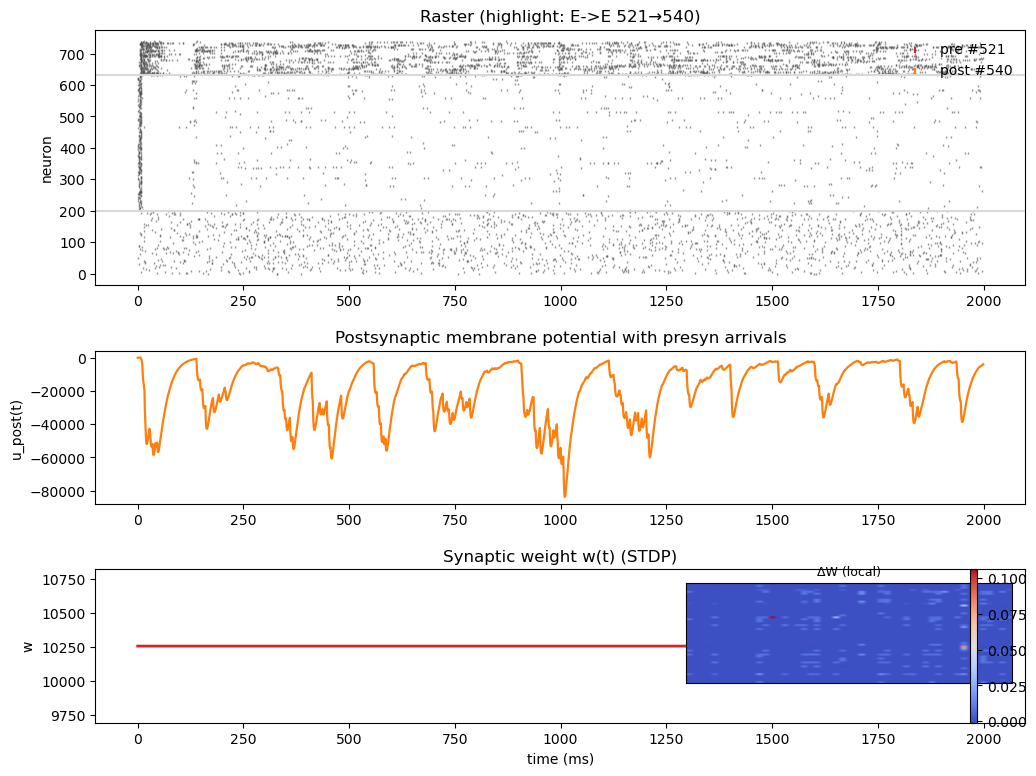

In [154]:
import numpy as np, matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

def _pick_plastic_edge(net, path="E->E"):
    m = (net.masks[path] & net.C & net.stdp_mask)
    if not np.any(m): return None
    jj, ii = np.nonzero(m)
    wabs = np.abs(net.W[m])
    k = int(np.argmax(wabs))
    return int(jj[k]), int(ii[k])

def viz_STDP_only(net, duration_ms=2000, bg_rate_hz=5.0, r_cap=200.0,
                  path="E->E", gamma_exc=1.5, seed=1, window_half=25,
                  restore_gamma=True):
    rng = np.random.default_rng(seed)
    dt = float(net.dt); T = int(round(duration_ms/dt)); N = net.N
    EI = (net.is_exc | net.is_inh)

    # pick a plastic synapse
    sel = _pick_plastic_edge(net, path=path)
    if sel is None: 
        raise RuntimeError(f"No plastic synapse found for path {path}.")
    j, i = sel

    # bump gamma (generic excitability) to drive recurrent spiking
    gamma_old = getattr(net, "gamma_exc", 1.0)
    Egen_old  = getattr(net, "E_generic_exc", 300.0*gamma_old)
    net.gamma_exc = float(gamma_exc); net.E_generic_exc = 300.0 * net.gamma_exc

    # logs
    S = np.zeros((N,T), int)
    U_post = np.zeros(T)
    W_tr   = np.zeros(T)

    kdelay = int(round(net.delays[j,i]/dt))
    lam_inp = bg_rate_hz * (dt/1000.0)
    rates_prev = np.zeros(N); rates_prev[EI] = net.r0

    # snapshot for ΔW
    W0 = net.W.copy()

    net.reset_state()
    for t in range(T):
        spikes = np.zeros(N,int)
        spikes[net.is_inp] = rng.poisson(lam_inp, size=net.is_inp.sum())
        lam_ei = np.clip(rates_prev[EI], 0.0, r_cap) * (dt/1000.0)
        spikes[EI] = rng.poisson(lam_ei)
        spikes = net.apply_refractory_and_update(spikes)
        out = net.step(spikes)

        S[:,t]   = spikes
        U_post[t]= out["u"][i]
        W_tr[t]  = net.W[j,i]

        phi = np.clip(net.alpha * out["u"], -50.0, np.log(net.r_cap / net.r0))
        rates_prev[:] = 0.0
        rates_prev[EI] = net.r0 * np.exp(phi)[EI]

    dW = net.W - W0
    # local ΔW window centered on (j,i)
    rows = np.flatnonzero(net.is_inp if path=="inp->E" else net.is_exc)
    cols = np.flatnonzero(net.is_exc)
    r0 = np.where(rows==j)[0][0]; c0 = np.where(cols==i)[0][0]
    r_sel = rows[max(0,r0-window_half): r0+window_half+1]
    c_sel = cols[max(0,c0-window_half): c0+window_half+1]
    dW_win = dW[np.ix_(r_sel, c_sel)]

    # ---- plots (vertical) ----
    t_ms = np.arange(T)*dt
    import matplotlib.gridspec as gridspec
    fig = plt.figure(figsize=(12,9))
    gs  = gridspec.GridSpec(3,1, height_ratios=[2.0,1.2,1.2], hspace=0.35)

    # Raster
    ax = fig.add_subplot(gs[0,0])
    n_idx, t_idx = np.nonzero(S>0)
    rep = S[n_idx, t_idx].astype(int)
    rr = np.repeat(np.arange(n_idx.size), rep)
    ax.scatter(t_idx[rr]*dt, n_idx[rr], s=2, marker="|", color="0.3", alpha=0.6, linewidths=1)
    ax.scatter(np.where(S[j]>0)[0]*dt, np.full(np.sum(S[j]>0), j), s=18, marker="|", color="C3", label=f"pre #{j}")
    ax.scatter(np.where(S[i]>0)[0]*dt, np.full(np.sum(S[i]>0), i), s=18, marker="|", color="C1", label=f"post #{i}")
    ax.axhline(net.N_inp-0.5, color='0.85'); ax.axhline(net.N_inp+net.N_exc-0.5, color='0.85')
    ax.set_title(f"Raster (highlight: {path} {j}→{i})"); ax.set_ylabel("neuron"); ax.legend(frameon=False, loc='upper right')

    # Postsyn u(t) + arrival markers
    ax = fig.add_subplot(gs[1,0])
    ax.plot(t_ms, U_post, color='C1', lw=1.6)
    arr = np.where(S[j]>0)[0] + kdelay; arr = arr[arr<T]
    if arr.size:
        ax.vlines(arr*dt, ymin=np.min(U_post), ymax=np.max(U_post), colors='C3', linestyles='dashed', alpha=0.5)
    ax.set_title("Postsynaptic membrane potential with presyn arrivals"); ax.set_ylabel("u_post(t)")

    # Weight trajectory + ΔW inset
    ax = fig.add_subplot(gs[2,0])
    ax.plot(t_ms, W_tr, color='C3', lw=2.0)
    ax.set_title("Synaptic weight w(t) (STDP)"); ax.set_xlabel("time (ms)"); ax.set_ylabel("w")
    axins = inset_axes(ax, width="35%", height="65%", loc="upper right", borderpad=1)
    im = axins.imshow(dW_win, cmap="coolwarm", aspect="auto")
    axins.set_title("ΔW (local)", fontsize=9); axins.set_xticks([]); axins.set_yticks([])
    plt.colorbar(im, ax=axins, fraction=0.06, pad=0.04)

    plt.tight_layout(); plt.show()

    if restore_gamma:
        net.gamma_exc = gamma_old; net.E_generic_exc = Egen_old

# Run (STDP on E->E; set path="inp->E" to view input→E plasticity)
viz_STDP_only(net, path="E->E", gamma_exc=2, duration_ms=2000, seed=2)


C:\Users\miles\AppData\Local\Temp\ipykernel_23960\2020231938.py:71: RuntimeWarning: invalid value encountered in divide
  eF = np.where(F > 0.0, np.exp(-Δt_ms / F), 0.0)
C:\Users\miles\AppData\Local\Temp\ipykernel_23960\2020231938.py:71: RuntimeWarning: divide by zero encountered in divide
  eF = np.where(F > 0.0, np.exp(-Δt_ms / F), 0.0)
C:\Users\miles\AppData\Local\Temp\ipykernel_23960\2667350774.py:114: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(); plt.show()


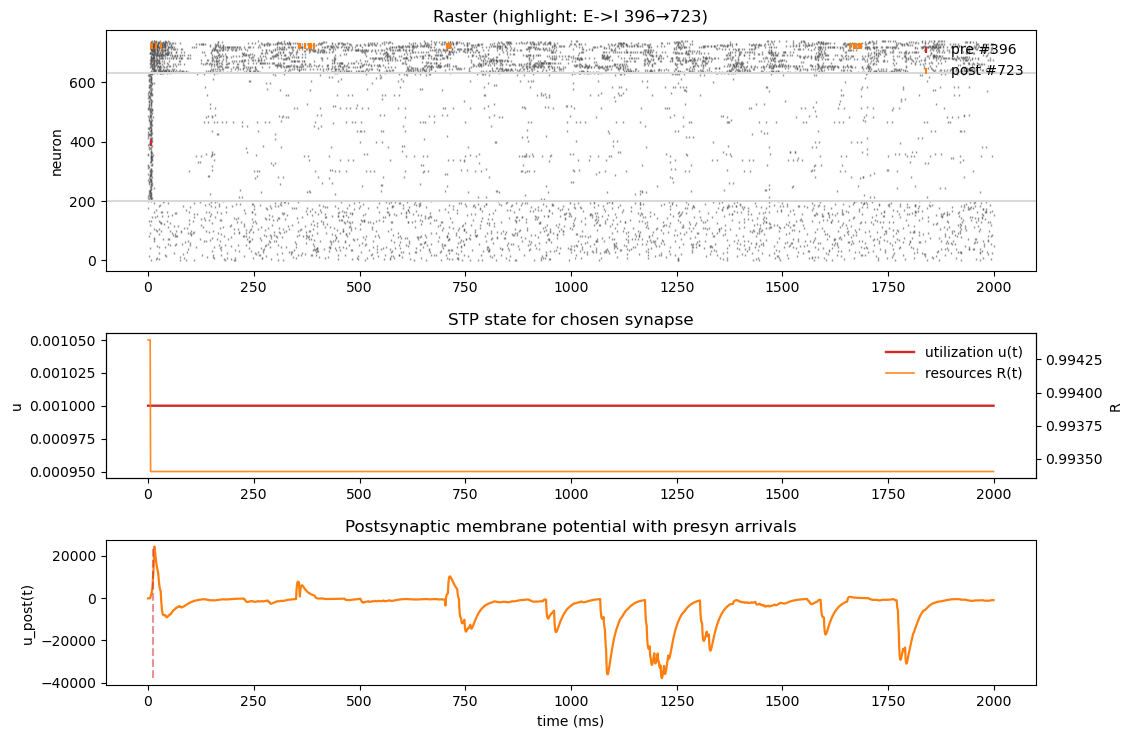

In [156]:
import numpy as np, matplotlib.pyplot as plt

def _pick_stp_edge(net, prefer=("E->I","I->E","E->E","I->I")):
    for k in prefer:
        m = net.masks[k] & net.C
        if np.any(m):
            jj, ii = np.nonzero(m)
            wabs = np.abs(net.W[m]); idx = int(np.argmax(wabs))
            return int(jj[idx]), int(ii[idx]), k
    return None

def _stp_entry(eng, j, i):
    byk = getattr(eng, "groups", None)
    if byk is None: byk = getattr(eng, "out_by_delay", None)
    if byk is None or j >= len(byk): return (None,None,None)
    for k,item in byk[j].items():
        if isinstance(item, dict):
            idx, A = item["i"], item["A"]; R = item.get("R",None); u = item.get("u",None)
            where = np.where(idx==i)[0]
            if where.size:
                Ri = R[where[0]:where[0]+1] if R is not None else None
                ui = u[where[0]:where[0]+1] if u is not None else None
                return (A[where[0]:where[0]+1], Ri, ui)
        else:
            idx, A = item
            if np.any(idx==i):
                return (A[np.where(idx==i)[0][0]:], None, None)
    return (None,None,None)

def viz_STP_only(net, duration_ms=2000, bg_rate_hz=5.0, r_cap=200.0,
                 gamma_exc=1.5, seed=3, prefer=("E->I","I->E"),restore_gamma=True):
    rng = np.random.default_rng(seed)
    dt = float(net.dt); T = int(round(duration_ms/dt)); N = net.N
    EI = (net.is_exc | net.is_inh)

    sel = _pick_stp_edge(net, prefer=prefer)
    if sel is None: raise RuntimeError("No edge found for STP viz.")
    j,i,path = sel
    # choose engine by presyn type
    eng = net._syn_exc if net.is_exc[j] else net._syn_inh

    # bump gamma
    gamma_old = getattr(net, "gamma_exc", 1.0)
    Egen_old  = getattr(net, "E_generic_exc", 300.0*gamma_old)
    net.gamma_exc = float(gamma_exc); net.E_generic_exc = 300.0 * net.gamma_exc

    # logs
    S = np.zeros((N,T), int)
    u_post = np.zeros(T); u_t = np.zeros(T); R_t = np.zeros(T)

    kdelay = int(round(net.delays[j,i]/dt))
    lam_inp = bg_rate_hz * (dt/1000.0)
    rates_prev = np.zeros(N); rates_prev[EI] = net.r0

    net.reset_state()
    for t in range(T):
        spikes = np.zeros(N,int)
        spikes[net.is_inp] = rng.poisson(lam_inp, size=net.is_inp.sum())
        lam_ei = np.clip(rates_prev[EI], 0.0, r_cap) * (dt/1000.0)
        spikes[EI] = rng.poisson(lam_ei)
        spikes = net.apply_refractory_and_update(spikes)
        out = net.step(spikes)

        S[:,t] = spikes
        u_post[t] = out["u"][i]
        # read current STP state
        A,Rv,uv = _stp_entry(eng, j, i)
        if Rv is not None: R_t[t] = float(Rv[0])
        if uv is not None: u_t[t] = float(uv[0])

        phi = np.clip(net.alpha * out["u"], -50.0, np.log(net.r_cap / net.r0))
        rates_prev[:] = 0.0
        rates_prev[EI] = net.r0 * np.exp(phi)[EI]

    # ---- plots (vertical) ----
    t_ms = np.arange(T)*dt
    import matplotlib.gridspec as gridspec
    fig = plt.figure(figsize=(12,8.5))
    gs  = gridspec.GridSpec(3,1, height_ratios=[2.0,1.2,1.2], hspace=0.35)

    # Raster
    ax = fig.add_subplot(gs[0,0])
    n_idx, t_idx = np.nonzero(S>0)
    rep = S[n_idx, t_idx].astype(int)
    rr = np.repeat(np.arange(n_idx.size), rep)
    ax.scatter(t_idx[rr]*dt, n_idx[rr], s=2, marker="|", color="0.3", alpha=0.6, linewidths=1)
    ax.scatter(np.where(S[j]>0)[0]*dt, np.full(np.sum(S[j]>0), j), s=18, marker="|", color='C3', label=f"pre #{j}")
    ax.scatter(np.where(S[i]>0)[0]*dt, np.full(np.sum(S[i]>0), i), s=18, marker="|", color='C1', label=f"post #{i}")
    ax.axhline(net.N_inp-0.5, color='0.85'); ax.axhline(net.N_inp+net.N_exc-0.5, color='0.85')
    ax.set_title(f"Raster (highlight: {path} {j}→{i})"); ax.set_ylabel("neuron"); ax.legend(frameon=False, loc='upper right')

    # STP state u(t) & R(t)
    ax = fig.add_subplot(gs[1,0])
    if np.any(u_t) or np.any(R_t):
        ax.plot(t_ms, u_t, color='C3', lw=1.7, label="utilization u(t)")
        ax2 = ax.twinx()
        ax2.plot(t_ms, R_t, color='C1', lw=1.2, alpha=0.9, label="resources R(t)")
        ax.set_ylabel("u"); ax2.set_ylabel("R")
        ax.set_title("STP state for chosen synapse")
        h1,l1 = ax.get_legend_handles_labels(); h2,l2 = ax2.get_legend_handles_labels()
        ax2.legend(h1+h2, l1+l2, frameon=False, loc='upper right')
    else:
        ax.text(0.5,0.5,"(engine state not exposed)", ha='center', va='center'); ax.set_axis_off()

    # Postsyn u(t) + arrivals
    ax = fig.add_subplot(gs[2,0])
    ax.plot(t_ms, u_post, color='C1', lw=1.6)
    arr = np.where(S[j]>0)[0] + kdelay; arr = arr[arr<T]
    if arr.size:
        ax.vlines(arr*dt, ymin=np.min(u_post), ymax=np.max(u_post), colors='C3', linestyles='dashed', alpha=0.5)
    ax.set_title("Postsynaptic membrane potential with presyn arrivals")
    ax.set_xlabel("time (ms)"); ax.set_ylabel("u_post(t)")

    plt.tight_layout(); plt.show()

    if restore_gamma:
        net.gamma_exc = gamma_old; net.E_generic_exc = Egen_old

# Run (prefers E->I to show facilitation; falls back if unavailable)
viz_STP_only(net, gamma_exc=2, duration_ms=2000, seed=4, prefer=("E->I","I->E"))


In [128]:
# === STP sanity checks (stand-alone) =========================================
import numpy as np

def steady_state_uR(U, D, F, r_hz):
    U = np.asarray(U, dtype=float)
    D = np.asarray(D, dtype=float)
    F = np.asarray(F, dtype=float)
    ISI = 1000.0 / max(r_hz, 1e-9)
    eD  = np.exp(-ISI / np.maximum(D, 1e-12))
    eF  = np.zeros_like(F, dtype=float)
    m = F > 0.0
    if np.any(m):
        eF[m] = np.exp(-ISI / F[m])
    u_star = U / (1.0 - (1.0 - U) * eF)
    u_star = np.clip(u_star, 1e-6, 1.0 - 1e-6)
    R_star = (1.0 - eD) / (1.0 - (1.0 - u_star) * eD)
    R_star = np.clip(R_star, 1e-6, 1.0)
    u_star = float(u_star) if u_star.shape == () else u_star
    R_star = float(R_star) if R_star.shape == () else R_star
    return u_star, R_star

def stp_sanity_checks(net, seed=0, f0=5.0):
    rng = np.random.default_rng(seed)

    # 1) Coverage & bounds per pathway
    print("— STP parameter coverage —")
    for key in ("E->E","E->I","I->E","I->I"):
        m = net.masks[key] & net.C
        n = int(m.sum())
        U = net.U_mat[m]; D = net.D_mat[m]; F = net.F_mat[m]
        if n:
            print(f"{key:4s}: N={n:6d} | U[{U.min():.3f},{U.max():.3f}]  "
                  f"D[{D.min():.1f},{D.max():.1f}] ms  F[{F.min():.1f},{F.max():.1f}] ms")
        else:
            print(f"{key:4s}: N=0")

    # 2) Closed-form (Eq.16–17) vs recurrence (Eq.12–14) at f0
    mask = (net.U_mat > 0)
    if np.any(mask):
        flat = np.flatnonzero(mask)
        take = rng.choice(flat, size=min(32, flat.size), replace=False)
        js, is_ = np.unravel_index(take, net.U_mat.shape)
        errs = []
        for j,i in zip(js,is_):
            U, D, F = net.U_mat[j,i], net.D_mat[j,i], net.F_mat[j,i]
            u_ss, R_ss = steady_state_uR(U, D, F, f0)
            g_ss = R_ss * u_ss

            # recurrence to steady state (pre-spike values)
            R_post = 1.0; u_prev = float(U)
            dt_ms = 1000.0 / f0
            g_hist = []
            for n in range(200):
                eD = np.exp(-dt_ms / max(float(D), 1e-12))
                eF = 0.0 if float(F) <= 0.0 else np.exp(-dt_ms / float(F))
                u_pre = u_prev * eF + float(U) * (1.0 - u_prev * eF)
                R_pre = 1.0 - (1.0 - R_post) * eD
                g = R_pre * u_pre
                R_post = R_pre * (1.0 - u_pre)
                u_prev = u_pre
                if n >= 100:
                    g_hist.append(g)
            g_mean = float(np.mean(g_hist))
            errs.append(abs(g_mean - g_ss) / max(1e-12, g_ss))
        print(f"Closed-form vs recurrence @ {f0} Hz — median rel.err={np.median(errs):.2e}, "
              f"max={np.max(errs):.2e}")
    else:
        print("No STP synapses to test.")

    # 3) Engine-level effect: one E neuron spiking at 5 Hz should drive a postsyn target
    exc_rows = np.flatnonzero(net.is_exc)
    j = None
    for jj in exc_rows:
        if np.any(net.C[jj]): j = int(jj); break
    if j is None:
        print("No excitatory presyn with outgoing targets found.")
        return

    targets = np.where(net.C[j])[0]
    i = int(targets[np.argmax(np.abs(net.W[j, targets]))])

    net.reset_state()
    T_ms = 1000
    T = int(round(T_ms / net.dt))
    steps = np.arange(0, T, int(round(1000.0 / 5.0)))  # 5 Hz regular
    z_i = []
    for t in range(T):
        spikes = np.zeros(net.N, int)
        if t in steps: spikes[j] = 1
        out = net.step(spikes)
        z_i.append(out["z"][i] if "z" in out else out["u"][i])

    z_i = np.asarray(z_i)
    k = int(round(net.delays[j,i] / net.dt))
    if k > 0 and steps.size:
        arr = steps + k
        arr = arr[arr < T]
        if arr.size:
            mean_at_arr = float(np.mean(z_i[arr]))
            mean_baseln = float(np.mean(z_i[np.clip(arr-5,0,T-1)]))
            print(f"Postsyn drive at arrivals j={j}→i={i}: mean@arrivals={mean_at_arr:.4f}, "
                  f"pre-arrival={mean_baseln:.4f}")
    print("Done.")

# Example:
net = SpikingNetwork(N_inp=200, N_exc=432, N_inh=108, dt_ms=1.0, rng=np.random.default_rng(1))
stp_sanity_checks(net, seed=0, f0=5.0)


— STP parameter coverage —
E->E: N= 93273 | U[0.001,0.999]  D[0.1,424.6] ms  F[0.0,0.0] ms
E->I: N=  6957 | U[0.001,0.516]  D[0.1,961.7] ms  F[0.0,3906.9] ms
I->E: N=  7970 | U[0.001,0.551]  D[0.1,115.1] ms  F[0.0,1312.3] ms
I->I: N=  1553 | U[0.001,0.702]  D[0.1,2031.4] ms  F[0.0,53.8] ms
Closed-form vs recurrence @ 5.0 Hz — median rel.err=1.74e-16, max=3.32e-13
Postsyn drive at arrivals j=200→i=729: mean@arrivals=0.0798, pre-arrival=0.1024
Done.


C:\Users\miles\AppData\Local\Temp\ipykernel_23960\3619641723.py:71: RuntimeWarning: divide by zero encountered in divide
  eF = np.where(F > 0.0, np.exp(-Δt_ms / F), 0.0)


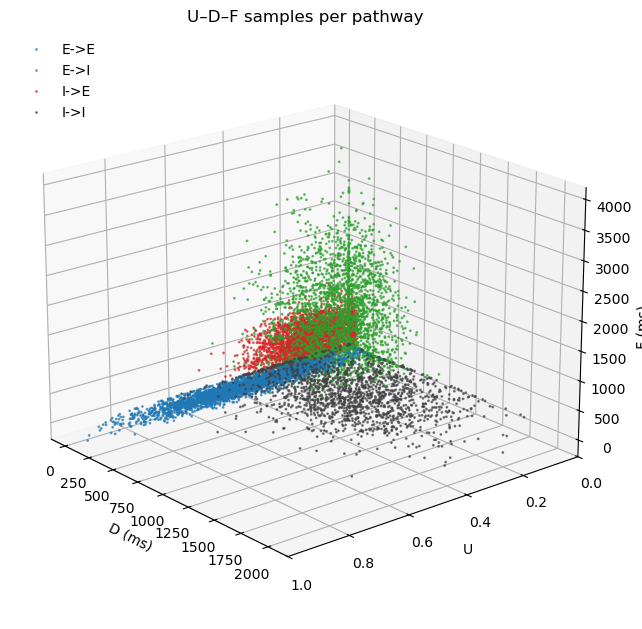

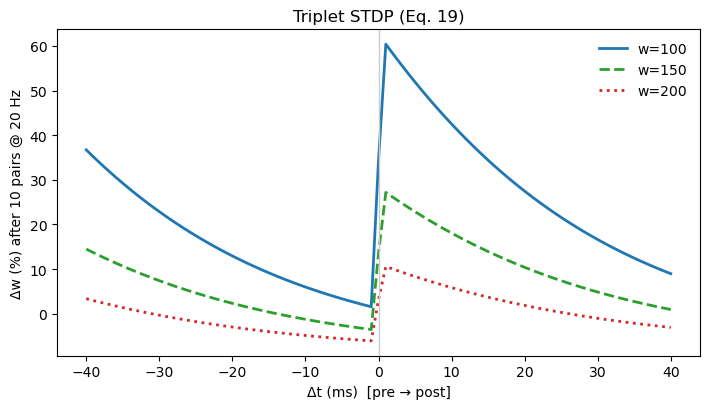

In [133]:
# ================= Figures B (U-D-F) and C (Δw vs Δt, triplet STDP) =================
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401

# ---------- Fig B: U–D–F scatter per pathway from your current 'net' ----------
def plot_udf_scatter_3d(net, max_points_per_type=3000, figsize=(8.6,6.4),
                        elev=20, azim=-40, flip_U=True):
    colors = {"E->E":"C0", "E->I":"C2", "I->E":"C3", "I->I":"0.25"}
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111, projection='3d')

    for key in ("E->E","E->I","I->E","I->I"):
        m = net.masks[key] & net.C
        if not np.any(m): 
            continue
        U = net.U_mat[m].ravel()
        D = net.D_mat[m].ravel()
        F = net.F_mat[m].ravel()
        if U.size > max_points_per_type:
            idx = np.random.default_rng(0).choice(U.size, size=max_points_per_type, replace=False)
            U, D, F = U[idx], D[idx], F[idx]
        ax.scatter(D, U, F, s=1,alpha=0.65, c=colors[key], label=key)

    ax.set_xlabel("D (ms)"); ax.set_ylabel("U"); ax.set_zlabel("F (ms)")
    ax.set_title("U–D–F samples per pathway")
    ax.legend(frameon=False, loc='upper left')
    if flip_U:
        ax.set_ylim(1.0, 0.0)     # U in [0,1], reversed
        # or: ax.invert_yaxis()
    ax.view_init(elev=elev, azim=azim)

    plt.tight_layout(); plt.show()

# ---------- Fig C: Δw(Δt) after 10 pairings @ 20 Hz using TRIPLET STDP (Eq. 19) ----------
def stdp_triplet_delta_w_percent(
        w0_list=(100,150,200),
        w_max=300.0,
        n_pairs=10, f_pair_hz=20.0,
        dt_axis=np.arange(-40, 41, 1),
        # detectors' time constants (ms)
        tau_r1=25.0, tau_r2=25.0, tau_o1=1000.0, tau_o2=25.0,
        # amplitudes
        A2p=10.0, A3p=10.0, A2m=0.5, A3m=0.5,
        seed=0
    ):
    """
    Triplet STDP (Pfister & Gerstner-style) per your Eq.(19):
      pre @ t:  Δw -= o1(t) * [A2m + A3m * r2(t^-)]
                then r1 += 1, r2 += 1
      post @ t: Δw += r1(t) * [A2p + A3p * o2(t^-)]
                then o1 += 1, o2 += 1
      Between events, r1,r2,o1,o2 decay exponentially with their taus.
    Multiplicative bounds: LTP * ((w_max - w)/w_max), LTD * (w/w_max).
    Returns: dt_axis, dict{w0: Δw_percent(Δt)}.
    """
    rng = np.random.default_rng(seed)
    T = 1000.0 / f_pair_hz  # ms period (20 Hz -> 50 ms)
    out = {}

    for w0 in w0_list:
        curve = []
        for dlt in dt_axis:
            # Build n_pairs of (pre, post) times: post = pre + Δt
            t_pre  = np.arange(n_pairs) * T
            t_post = t_pre + dlt
            # Concatenate, sort
            times = np.concatenate([t_pre, t_post])
            kinds = np.concatenate([np.full_like(t_pre, +1), np.full_like(t_post, -1)])  # +1=pre, -1=post
            order = np.argsort(times)
            times, kinds = times[order], kinds[order]

            # Detectors and weight
            r1 = 0.0; r2 = 0.0; o1 = 0.0; o2 = 0.0
            w = float(w0)
            t_last = times[0] if times.size else 0.0

            for t, kind in zip(times, kinds):
                # decay since last event
                dt = t - t_last
                if dt > 0:
                    r1 *= np.exp(-dt / tau_r1)
                    r2 *= np.exp(-dt / tau_r2)
                    o1 *= np.exp(-dt / tau_o1)
                    o2 *= np.exp(-dt / tau_o2)
                t_last = t

                if kind == +1:  # PRE at time t
                    # epsilon convention: use r2 before increment
                    ltd = o1 * (A2m + A3m * r2)
                    w += - ltd * (w / w_max)            # multiplicative LTD
                    r1 += 1.0
                    r2 += 1.0
                else:           # POST at time t
                    # epsilon convention: use o2 before increment
                    ltp = r1 * (A2p + A3p * o2)
                    w += + ltp * ((w_max - w) / w_max)  # multiplicative LTP
                    o1 += 1.0
                    o2 += 1.0

            curve.append(100.0 * (w - w0) / max(1e-12, w0))
        out[w0] = np.array(curve)
    return dt_axis, out

def plot_triplet_stdp(dt_axis, curves, figsize=(7.2,4.2)):
    # map initial weight → (color, linestyle)
    style = {
        100: ("C0", "-"),   # blue solid
        150: ("C2", "--"),  # green dashed
        200: ("C3", ":"),   # red dotted
    }
    plt.figure(figsize=figsize)
    for w0, y in curves.items():
        c, ls = style.get(w0, ("0.2", "-"))
        plt.plot(dt_axis, y, lw=2, color=c, linestyle=ls, label=f"w={w0}")
    plt.axvline(0, color='0.8', lw=1)
    plt.xlabel("Δt (ms)  [pre → post]")
    plt.ylabel("Δw (%) after 10 pairs @ 20 Hz")
    plt.title("Triplet STDP (Eq. 19)")
    plt.legend(frameon=False)
    plt.tight_layout(); plt.show()


# -------------------- Run both figures --------------------
# Fig B from your current 'net'
plot_udf_scatter_3d(net)

# Fig C with the triplet rule + your parameters
dt_axis, curves = stdp_triplet_delta_w_percent(
    w0_list=(100,150,200), w_max=300.0, n_pairs=10, f_pair_hz=20.0,
    tau_r1=25.0, tau_r2=25.0, tau_o1=1000.0, tau_o2=25.0,
    A2p=10.0, A3p=10.0, A2m=0.5, A3m=0.5
)
plot_triplet_stdp(dt_axis, curves)


In [62]:
# external input drive (inputs only)
lam_inp = rate_inp_hz * (net.dt / 1000.0)
rates_prev = np.zeros(net.N); rates_prev[net.is_exc | net.is_inh] = net.r0

for t in range(T):
    spikes = np.zeros(net.N, int)
    spikes[net.is_inp] = net.rng.poisson(lam_inp, size=net.is_inp.sum())  # inputs
    spikes += net.sample_recurrent_spikes(rates_prev)                      # E/I with refractory
    out = net.step(spikes)
    rates_prev = out["r"] * (net.is_exc | net.is_inh)  # only E/I recur


NameError: name 'rate_inp_hz' is not defined

# Unit Tests

In [89]:
# build once
net = SpikingNetwork(N_inp=200, N_exc=432, N_inh=108, dt_ms=1.0)

# example external drive: constant Poisson for inputs, zero elsewhere
# --- NEW: create one triple of input patterns for this simulation ---
rng_local = np.random.default_rng(123)  # or reuse net.rng for reproducibility
patterns = sample_pattern_triple(rng_local, N_inp=net.N_inp, on=20, max_overlap=2)

# e.g., add 100 ms gaps to actually see idle periods
stim = PatternStimulus(
    net, patterns,
    rate_on=40.0,
    rate_bg_present=3.0,
    rate_bg_idle=5.0,
    present_ms=100.0,
    gap_ms=100.0,                  # <- set >0 to include idle; 0 means no idle
    order=("blue", "green", "red")
)

print({k: patterns[k].tolist()[:5] for k in patterns})  # peek a few indices

T = 500
logs_u, logs_r = [], []
for t in range(T):
    rates_step = stim.rates_at_step(t)  # Hz, full length N (only inputs nonzero)
    spikes[net.is_inp] = rng_local.poisson(rates_step[net.is_inp] * (net.dt / 1000.0))
    out = net.step(spikes)
    logs_u.append(out["u"]); logs_r.append(out["r"])
logs_u = np.stack(logs_u, axis=1)  # (N, T)
logs_r = np.stack(logs_r, axis=1)


{'blue': [4, 21, 24, 28, 29], 'green': [0, 1, 6, 9, 15], 'red': [5, 23, 24, 25, 38]}


In [21]:
import numpy as np
import time
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

def discrete_kernel(dt, t_rise, t_fall, T_eps, K=1.0):
    af = np.exp(-dt / t_fall); ar = np.exp(-dt / t_rise)
    L = int(round(T_eps / dt)) + 1
    n = np.arange(L)
    return K * (af**n - ar**n)

def mean_cv(x):
    x = np.asarray(x)
    m = x.mean()
    s = x.std(ddof=0)
    return m, (s / m) if m != 0 else np.nan


In [33]:
def test_connectivity_stats(net, atol=0.01):
    print("Connectivity fractions (realized vs target):")
    ok = True
    for k, m in net.masks.items():
        tgt = net.conn_specs[k]["p"]
        if not m.any(): 
            print(f"{k:7s}: mask empty"); continue
        realized = net.C[m].mean()
        print(f"{k:7s}: {realized:.3f} (target {tgt:.3f})")
        ok &= (abs(realized - tgt) <= max(atol, 0.1*tgt))  # loose tolerance
    return ok

ok = test_connectivity_stats(net)


Connectivity fractions (realized vs target):
E->E   : 0.498 (target 0.500)
E->I   : 0.142 (target 0.040)
I->E   : 0.163 (target 0.050)
I->I   : 0.120 (target 0.040)
inp->E : 0.500 (target 0.500)


In [34]:
def test_weight_signs_and_stats(net, rel_tol=0.25):
    ok = True
    print("Weight stats (abs value) and sign checks:")
    for k, (mean_t, cv_t, sign_t) in net.weight_specs.items():
        m = net.masks[k] & net.C
        w = net.W[m]
        if w.size == 0:
            print(f"{k:7s}: no edges"); continue
        # sign check
        if "I->" in k:
            sign_ok = np.all(w <= 0)
        else:
            sign_ok = np.all(w >= 0)
        # mean/CV of magnitudes
        mu, cv = mean_cv(np.abs(w))
        print(f"{k:7s}: mean={mu:.3g} (tgt {mean_t:.3g}), cv={cv:.2f} (tgt {cv_t:.2f}), sign_ok={sign_ok}")
        ok &= sign_ok and (abs(mu-mean_t) <= rel_tol*mean_t)
    return ok

ok = test_weight_signs_and_stats(net)


Weight stats (abs value) and sign checks:
E->E   : mean=2.49 (tgt 2.5), cv=0.70 (tgt 0.70), sign_ok=True
E->I   : mean=994 (tgt 1e+03), cv=0.70 (tgt 0.70), sign_ok=True
I->E   : mean=1.38e+03 (tgt 1.38e+03), cv=0.70 (tgt 0.70), sign_ok=True
I->I   : mean=6.02e+03 (tgt 6e+03), cv=0.72 (tgt 0.70), sign_ok=True
inp->E : mean=15 (tgt 15), cv=0.07 (tgt 0.07), sign_ok=True


In [35]:
def test_delay_stats(net, rel_tol=0.35):
    ok = True
    print("Delay stats (ms):")
    for k, (mean_t, cv_t) in net.delay_specs.items():
        m = net.masks[k] & net.C
        d = net.delays[m]
        if d.size == 0:
            print(f"{k:7s}: no edges"); continue
        mu, cv = mean_cv(d)
        nonneg = np.all(d > 0)
        print(f"{k:7s}: mean={mu:.2f} (tgt {mean_t:.2f}), cv={cv:.2f} (tgt {cv_t:.2f}), >0={nonneg}")
        ok &= nonneg and (abs(mu-mean_t) <= rel_tol*mean_t)
    return ok

ok = test_delay_stats(net)


Delay stats (ms):
E->E   : mean=5.12 (tgt 5.00), cv=0.46 (tgt 0.50), >0=True
E->I   : mean=5.19 (tgt 5.00), cv=0.45 (tgt 0.50), >0=True
I->E   : mean=2.07 (tgt 2.00), cv=0.45 (tgt 0.50), >0=True
I->I   : mean=2.02 (tgt 2.00), cv=0.46 (tgt 0.50), >0=True
inp->E : mean=2.07 (tgt 2.00), cv=0.45 (tgt 0.50), >0=True


In [46]:
def test_engine_kernel_and_delay(dt=1.0, t_r=2.0, t_f=20.0, delay_ms=7.0, K=1.0, T=140):
    W = np.array([[1.0]]); D = np.array([[delay_ms]])
    eng = DelayedDoubleExpSynapses(W, D, dt, t_r, t_f, K)  # no truncation
    out = np.zeros(T)
    spikes = np.zeros((1, T)); spikes[0, 0] = 1
    for t in range(T):
        out[t] = eng.step(spikes[:, t])[0]

    # infinite-support reference
    n = np.arange(T)
    ker_inf = K * (np.exp(-n / t_f) - np.exp(-n / t_r))
    k = int(round(delay_ms/dt))
    exp = np.zeros(T); exp[k:] = ker_inf[:T-k]
    np.testing.assert_allclose(out, exp, rtol=1e-12, atol=1e-12)
    print("OK: engine matches infinite-support double-exp with delay.")

test_engine_kernel_and_delay()


OK: engine matches infinite-support double-exp with delay.


In [47]:
def test_network_vector_equivalence_small():
    rng = np.random.default_rng(3)
    N_pre, N_post, T = 8, 6, 200
    dt, t_r, t_f, T_eps, K = 1.0, 2.0, 20.0, 100.0, 1.0

    # random sparse weights and delays
    W = np.zeros((N_pre, N_post))
    mask = rng.random((N_pre, N_post)) < 0.25
    W[mask] = rng.normal(0.5, 0.2, size=mask.sum()) * rng.choice([1,-1], size=mask.sum())
    D = np.zeros_like(W); D[mask] = rng.integers(0, 8, size=mask.sum()).astype(float)

    # spikes
    spikes = np.zeros((N_pre, T), int)
    for j in range(N_pre):
        idx = rng.integers(0, T, size=6)
        spikes[j, idx] = rng.integers(1, 3, size=idx.size)

    # event-driven
    ev = DelayedDoubleExpSynapses(W, D, dt, t_r, t_f, K)
    U_ev = np.zeros((N_post, T))
    for t in range(T): U_ev[:, t] = ev.step(spikes[:, t])

    # direct reference by convolution with discrete kernel
    n = np.arange(T)
    ker = K * (np.exp(-n / t_f) - np.exp(-n / t_r))    # infinite-support, length T
    F = np.stack([np.convolve(spikes[j], ker)[:T] for j in range(N_pre)], axis=0)
    d_samp = np.rint(D / dt).astype(int)
    U_ref = np.zeros((N_post, T))
    for i in range(N_post):
        for j in range(N_pre):
            if W[j, i] != 0:
                k = d_samp[j, i]
                if k < T:
                    U_ref[i, k:] += W[j, i] * F[j, :T-k]
    np.testing.assert_allclose(U_ev, U_ref, rtol=1e-10, atol=1e-10)
    print("OK: event-driven equals vectorized reference on a small random net.")

test_network_vector_equivalence_small()


OK: event-driven equals vectorized reference on a small random net.


In [49]:
class _DenseDelayBucket:
    def __init__(self, W, delays_ms, dt, t_r, t_f, K=1.0):
        self.W = W; self.dt = dt; self.K = K
        self.N_pre, self.N_post = W.shape
        self.af = np.exp(-dt / t_f); self.ar = np.exp(-dt / t_r)
        d = np.rint(delays_ms / dt).astype(int)
        self.L = int(d.max(initial=0)) + 1
        self.Wk = [np.where(d == k, W, 0.0) for k in range(self.L)]
        self.gf = np.zeros(self.N_pre); self.gr = np.zeros(self.N_pre)
        self.buf = np.zeros((self.L, self.N_pre)); self.p = 0
    def step(self, spikes_pre):
        self.gf = self.af * self.gf + spikes_pre
        self.gr = self.ar * self.gr + spikes_pre
        f = self.K * (self.gf - self.gr)
        self.buf[self.p] = f
        U = np.zeros(self.N_post)
        for k in range(self.L):
            U += self.Wk[k].T @ self.buf[(self.p - k) % self.L]
        self.p = (self.p + 1) % self.L
        return U

def bench_event_vs_dense(N=1000, density=0.02, T=1000, rate_hz=5.0, seed=7, T_eps_ms=None):
    rng = np.random.default_rng(seed)
    dt, t_r, t_f, K = 1.0, 2.0, 20.0, 1.0

    # --- build one W/delays and reuse ---
    W = np.zeros((N, N))
    mask = rng.random((N, N)) < density
    W[mask] = rng.normal(0.5, 0.2, size=mask.sum()) * rng.choice([1, -1], size=mask.sum())
    delays = np.zeros_like(W); delays[mask] = rng.integers(0, 11, size=mask.sum()).astype(float)

    # --- SIMPLE FIX #1: same spikes for both engines ---
    lam = rate_hz * (dt / 1000.0)
    spikes = rng.poisson(lam, size=(N, T))   # <— generate once

    # --- engines (use same truncation mode on both; None = infinite-tail) ---
    ev = DelayedDoubleExpSynapses(W, delays, dt, t_r, t_f, K)
    de = _DenseDelayBucket(W, delays, dt, t_r, t_f, K)

    U_ev = np.zeros((N, T)); U_de = np.zeros((N, T))

    import time
    t0 = time.perf_counter()
    for t in range(T):
        U_ev[:, t] = ev.step(spikes[:, t])   # <— reuse
    t1 = time.perf_counter()
    for t in range(T):
        U_de[:, t] = de.step(spikes[:, t])   # <— reuse
    t2 = time.perf_counter()

    # if you haven't added T_eps_ms to _DenseDelayBucket, just drop that arg above
    np.testing.assert_allclose(U_ev, U_de, rtol=1e-9, atol=1e-9)
    print(f"OK (match). Event-driven: {t1-t0:.3f}s, Dense: {t2-t1:.3f}s")


bench_event_vs_dense(N=800, density=0.02, T=800)


OK (match). Event-driven: 0.222s, Dense: 2.540s


In [71]:
import numpy as np

# 1) Excitability sampling: log of (ind + 600) ~ N(μ=2.64, σ=0.23)
def test_excitability_distributions(net, mu=2.64, sigma=0.23, tol_mean=0.06, tol_std=0.05):
    x_exc = net.E_ind_exc[net.is_exc] + 600.0
    x_inh = net.I_ind_inh[net.is_inh] + 600.0
    assert np.all(x_exc > 0) and np.all(x_inh > 0), "lognormal draws must be >0 before shift"
    z_exc = np.log(x_exc); z_inh = np.log(x_inh)
    m_exc, s_exc = z_exc.mean(), z_exc.std(ddof=0)
    m_inh, s_inh = z_inh.mean(), z_inh.std(ddof=0)
    print(f"E: mean={m_exc:.3f} (target {mu}), std={s_exc:.3f} (target {sigma})")
    print(f"I: mean={m_inh:.3f} (target {mu}), std={s_inh:.3f} (target {sigma})")
    assert abs(m_exc-mu) < tol_mean and abs(s_exc-sigma) < tol_std
    assert abs(m_inh-mu) < tol_mean and abs(s_inh-sigma) < tol_std
    print("OK: excitability lognormal parameters within tolerance.")

# 2) Generic scaling: Δu_exc = 300·Δγ, inhibitory unchanged (no spikes)
def test_generic_scaling_effect(seed=123, gamma1=1.0, gamma2=1.4):
    rng1 = np.random.default_rng(seed)
    rng2 = np.random.default_rng(seed)
    net1 = SpikingNetwork(rng=rng1); net2 = SpikingNetwork(rng=rng2)
    net1.gamma_exc = gamma1; net1.E_generic_exc = 300.0*gamma1
    net2.gamma_exc = gamma2; net2.E_generic_exc = 300.0*gamma2

    z = np.zeros(net1.N, int)
    out1 = net1.step(z); out2 = net2.step(z)
    du = out2["u"] - out1["u"]

    e = net1.is_exc; i = net1.is_inh
    delta = 300.0*(gamma2-gamma1)
    assert np.allclose(du[e], delta), "Excitatory u must shift by 300·Δγ"
    assert np.allclose(du[i], 0.0),   "Inhibitory u must not change with γ_exc"
    print("OK: γ_exc shifts excitatory u(t) by 300·Δγ only.")

# 3) Bias-only membrane potential (no spikes): u = bias, r = r0·exp(0.25·bias)
def test_u_bias_no_spikes(net):
    net.reset_state()
    z = np.zeros(net.N, int)
    out = net.step(z)
    bias = np.zeros(net.N)
    bias[net.is_exc] = net.E_ind_exc[net.is_exc] + net.E_generic_exc
    bias[net.is_inh] = net.I_ind_inh[net.is_inh] + net.I_generic_inh
    assert np.allclose(out["y"], 0) and np.allclose(out["z"], 0) and np.allclose(out["h"], 0)
    assert np.allclose(out["u"], bias)
    assert np.allclose(out["r"], net.r0 * np.exp(0.25*bias))
    print("OK: u and r match pure excitability bias with no spikes.")

# 4) No external inputs to inhibitory: y[inh] stays zero under input drive
def test_inhibitory_no_input(net, steps=10, rate_inp_hz=8.0, seed=0):
    rng = np.random.default_rng(seed)
    net.reset_state()
    lam_inp = rate_inp_hz * (net.dt/1000.0)
    inh = net.is_inh
    for _ in range(steps):
        spikes = np.zeros(net.N, int)
        spikes[net.is_inp] = rng.poisson(lam_inp, size=net.is_inp.sum())
        out = net.step(spikes)
        assert np.allclose(out["y"][inh], 0.0), "inp->I should be absent; y[inh] must be zero."
    print("OK: inhibitory neurons receive no direct input drive (y[inh]==0).")

# 5) Refractory draws: mean durations ≈ 10 ms (E) and 3 ms (I)
def test_refractory_means(net, seed=7, k=2.0, tol_ms_exc=1.5, tol_ms_inh=1.0):
    rng = np.random.default_rng(seed)
    net.ref_remaining[:] = 0
    # propose a spike for all E/I
    spikes = np.zeros(net.N, int)
    spikes[net.is_exc | net.is_inh] = 1
    spikes = net.apply_refractory_and_update(spikes)
    # durations in steps right after first spike
    steps_e = net.ref_remaining[net.is_exc]
    steps_i = net.ref_remaining[net.is_inh]
    mean_e = steps_e.mean() * net.dt
    mean_i = steps_i.mean() * net.dt
    print(f"mean refractory: E≈{mean_e:.2f} ms (target 10), I≈{mean_i:.2f} ms (target 3)")
    assert abs(mean_e - net.ref_mean_ms_exc) < tol_ms_exc
    assert abs(mean_i - net.ref_mean_ms_inh) < tol_ms_inh
    print("OK: refractory mean durations near targets.")

# 6) Refractory blocks spikes while active, allows after countdown
def test_refractory_blocks_and_releases(net):
    """
    Convention under test: at each step, we first decrement ref counters,
    then block spikes where ref>0, then start new refractory for fired neurons.
    => A neuron with initial refractory k may spike again no earlier than step t=k.
    """
    net.ref_remaining[:] = 0
    ei = (net.is_exc | net.is_inh)

    # step 0: everyone in E/I fires once -> refractory is started
    spikes0 = np.zeros(net.N, int); spikes0[ei] = 1
    _ = net.apply_refractory_and_update(spikes0)
    steps0 = net.ref_remaining.copy()
    assert np.all(steps0[ei] >= 1)

    # steps 1..T: propose a spike each step; record the first time it gets through
    T = int(steps0.max()) + 2  # enough time for all to clear
    first_seen = np.full(net.N, np.inf)
    for t in range(1, T+1):  # t=1 means "one step after initial spike"
        want = np.zeros(net.N, int); want[ei] = 1
        out_spk = net.apply_refractory_and_update(want)
        just_seen = (out_spk > 0) & (first_seen == np.inf)
        first_seen[just_seen] = t

    # Check: earliest allowed time is t >= k
    bad_mask = (first_seen[ei] < steps0[ei])
    if np.any(bad_mask):
        bad_idx = np.where(bad_mask)[0][:10]
        raise AssertionError(
            f"Early spikes before refractory expired for neurons {bad_idx} "
            f"(first_seen={first_seen[bad_idx]}, initial_ref={steps0[bad_idx]})"
        )
    print("OK: spikes are blocked until refractory expires and allowed immediately after.")


# 7) Rate identity holds under activity: r == r0·exp(0.25·u) for random spikes
def test_rate_identity_under_activity(net, steps=50, seed=0, rate_inp_hz=6.0):
    rng = np.random.default_rng(seed)
    net.reset_state()
    lam_inp = rate_inp_hz * (net.dt/1000.0)
    for _ in range(steps):
        spikes = np.zeros(net.N, int)
        spikes[net.is_inp] = rng.poisson(lam_inp, size=net.is_inp.sum())
        out = net.step(spikes)
        assert np.allclose(out["r"], net.r0 * np.exp(0.25*out["u"]), rtol=1e-12, atol=1e-12)
    print("OK: r-u mapping holds during driven activity.")


In [72]:
# assumes an already-constructed net = SpikingNetwork(rng=..., ...)
test_excitability_distributions(net)
test_generic_scaling_effect()
test_u_bias_no_spikes(net)
test_inhibitory_no_input(net)
test_refractory_means(net)
test_refractory_blocks_and_releases(net)
test_rate_identity_under_activity(net)


E: mean=2.636 (target 2.64), std=0.244 (target 0.23)
I: mean=2.625 (target 2.64), std=0.239 (target 0.23)
OK: excitability lognormal parameters within tolerance.
OK: γ_exc shifts excitatory u(t) by 300·Δγ only.
OK: u and r match pure excitability bias with no spikes.
OK: inhibitory neurons receive no direct input drive (y[inh]==0).
mean refractory: E≈10.98 ms (target 10), I≈3.21 ms (target 3)
OK: refractory mean durations near targets.
OK: spikes are blocked until refractory expires and allowed immediately after.
OK: r-u mapping holds during driven activity.


# Visualizations

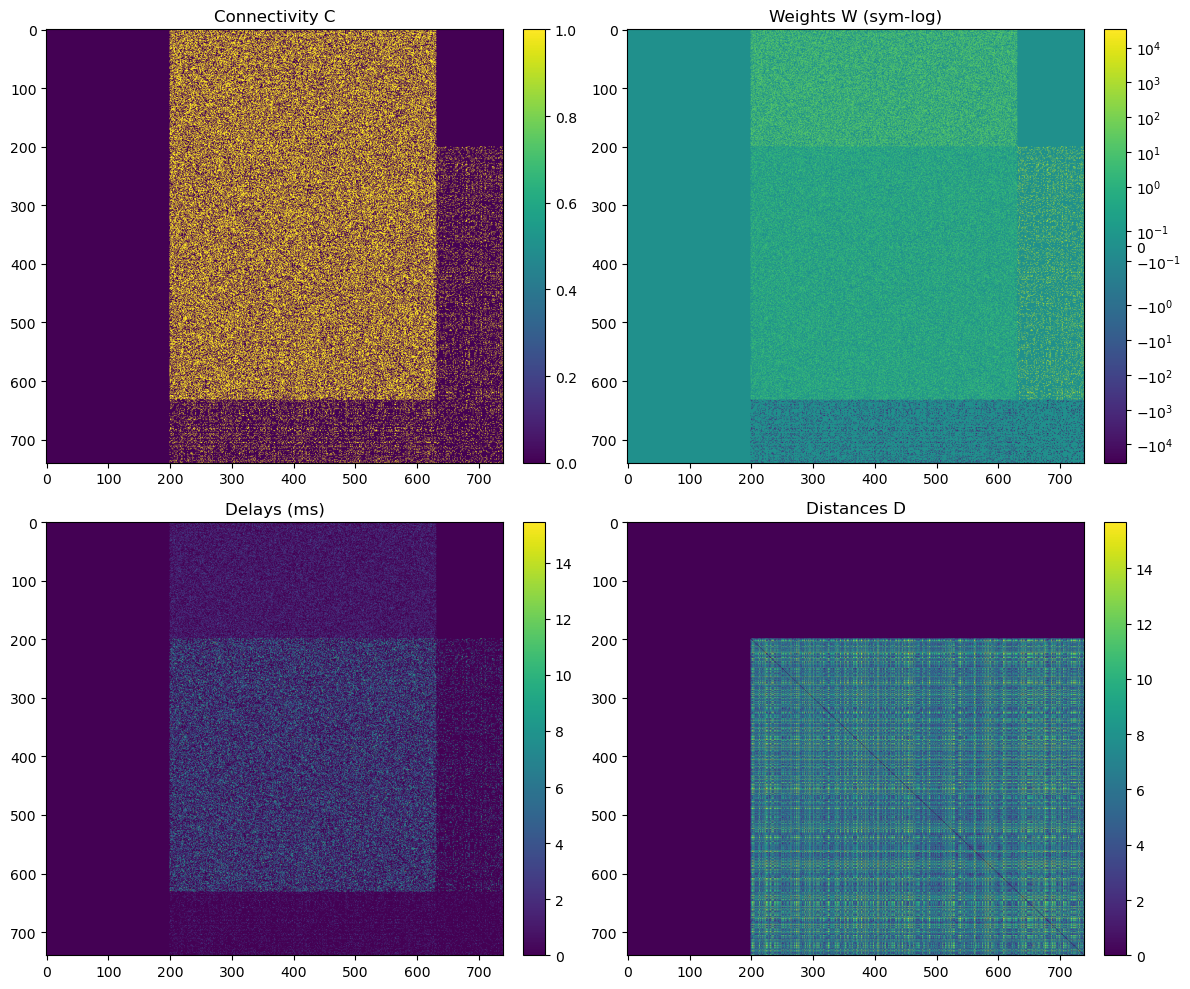

In [39]:
def viz_matrices(net):
    fig, ax = plt.subplots(2, 2, figsize=(12, 10))
    ims = []
    ims.append(ax[0,0].imshow(net.C, aspect='auto'));             ax[0,0].set_title("Connectivity C")
    # sym-log for signed W
    W = net.W
    nz = np.abs(W[W != 0]); vmax = nz.max() if nz.size else 1.0
    linth = np.percentile(nz, 1) if nz.size else 1e-3
    normW = mcolors.SymLogNorm(linthresh=linth, vmin=-vmax, vmax=vmax, base=10)
    ims.append(ax[0,1].imshow(W, aspect='auto', norm=normW));     ax[0,1].set_title("Weights W (sym-log)")
    ims.append(ax[1,0].imshow(net.delays, aspect='auto'));        ax[1,0].set_title("Delays (ms)")
    ims.append(ax[1,1].imshow(net.D, aspect='auto'));             ax[1,1].set_title("Distances D")
    for im, a in zip(ims, ax.ravel()):
        fig.colorbar(im, ax=a, fraction=0.046, pad=0.04)
    plt.tight_layout(); plt.show()

viz_matrices(net)


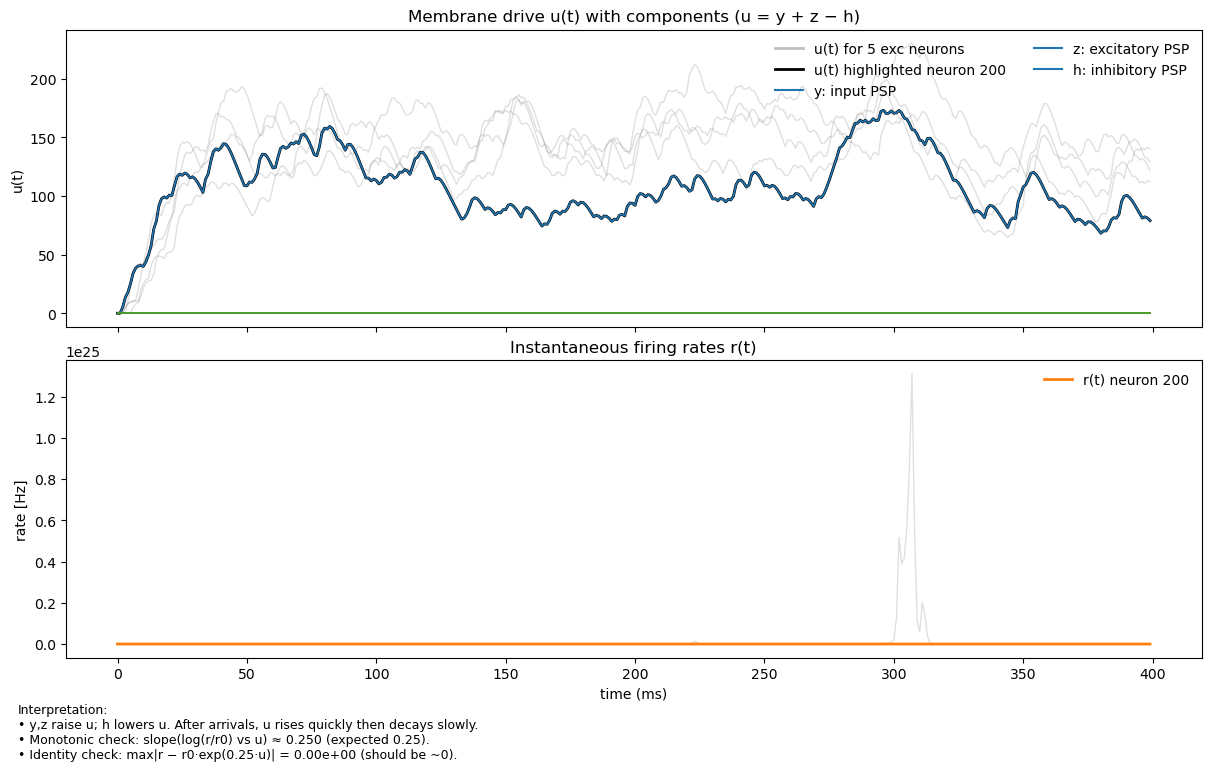

In [55]:
def viz_time_traces(net, T=300, rate_inp=5.0, n_show=5, seed=0):
    """
    Plots:
      (A) Membrane drive u(t) with a decomposition u = y + z - h for one neuron.
      (B) Firing rates r(t). A small diagnostic confirms r = r0 * exp(0.25 * u).
    What to look for:
      • y (inputs) and z (exc) push u up; h (inh) pulls u down.
      • After arrivals, u rises fast (~τ_rise) and decays slower (~τ_fall).
      • r(t) increases monotonically with u(t); slope check ≈ 0.25.
    """
    rng = np.random.default_rng(seed)
    rates = np.zeros(net.N); rates[net.is_inp] = rate_inp

    net.reset_state()
    Ys, Zs, Hs, Us, Rs = [], [], [], [], []
    for _ in range(T):
        spikes = rng.poisson(rates * (net.dt/1000.0))
        out = net.step(spikes)
        Ys.append(out["y"]); Zs.append(out["z"]); Hs.append(out["h"])
        Us.append(out["u"]); Rs.append(out["r"])

    Y = np.stack(Ys, axis=1)
    Z = np.stack(Zs, axis=1)
    H = np.stack(Hs, axis=1)
    U = np.stack(Us, axis=1)
    R = np.stack(Rs, axis=1)

    # choose neurons to show
    idx = np.flatnonzero(net.is_exc)[:max(1, n_show)]
    i0 = int(idx[0])  # highlight this one

    t = np.arange(T) * net.dt

    import matplotlib.pyplot as plt
    from matplotlib.lines import Line2D
    fig, ax = plt.subplots(2, 1, figsize=(12, 7), sharex=True, constrained_layout=True)

    # (A) u(t) + components for one neuron
    ax[0].plot(t, U[idx].T, color='0.5', alpha=0.25, linewidth=1)
    ax[0].plot(t, U[i0], color='k', linewidth=2)
    ax[0].plot(t, Y[i0], label='y: input PSP', linewidth=1.2)
    ax[0].plot(t, Z[i0], label='z: excitatory PSP', linewidth=1.2)
    ax[0].plot(t, H[i0], label='h: inhibitory PSP', linewidth=1.2)

    # legend (use proxies so we don’t list all gray traces)
    proxies = [
        Line2D([], [], color='0.5', alpha=0.5, lw=2, label=f'u(t) for {len(idx)} exc neurons'),
        Line2D([], [], color='k', lw=2, label=f'u(t) highlighted neuron {i0}'),
        Line2D([], [], lw=1.5, label='y: input PSP'),
        Line2D([], [], lw=1.5, label='z: excitatory PSP'),
        Line2D([], [], lw=1.5, label='h: inhibitory PSP'),
    ]
    ax[0].legend(handles=proxies, ncol=2, frameon=False, loc='upper right')
    ax[0].set_title("Membrane drive u(t) with components (u = y + z − h)")
    ax[0].set_ylabel("u(t)")

    # (B) r(t); include a tiny diagnostic on the u→r mapping
    ax[1].plot(t, R[idx].T, color='0.5', alpha=0.25, linewidth=1)
    ax[1].plot(t, R[i0], color='C1', linewidth=2, label=f'r(t) neuron {i0}')
    ax[1].set_title("Instantaneous firing rates r(t)")
    ax[1].set_xlabel("time (ms)")
    ax[1].set_ylabel("rate [Hz]")
    ax[1].legend(frameon=False, loc='upper right')

    # Diagnostic: check r = r0 * exp(0.25*u)
    u0 = U[i0]
    r0 = net.r0
    # slope of log(r/r0) vs u should be ~0.25
    x = u0 - u0.mean()
    y = np.log(np.maximum(R[i0], 1e-30) / r0) - np.log(np.maximum(R[i0], 1e-30) / r0).mean()
    slope = (x @ y) / (x @ x) if (x @ x) > 0 else np.nan
    max_err = float(np.max(np.abs(R[i0] - r0 * np.exp(0.25 * u0))))
    fig.text(
        0.01, -.08,
        f"Interpretation:\n"
        f"• y,z raise u; h lowers u. After arrivals, u rises quickly then decays slowly.\n"
        f"• Monotonic check: slope(log(r/r0) vs u) ≈ {slope:.3f} (expected 0.25).\n"
        f"• Identity check: max|r − r0·exp(0.25·u)| = {max_err:.2e} (should be ~0).",
        fontsize=9, va='bottom'
    )
    plt.show()


viz_time_traces(net, T=400)


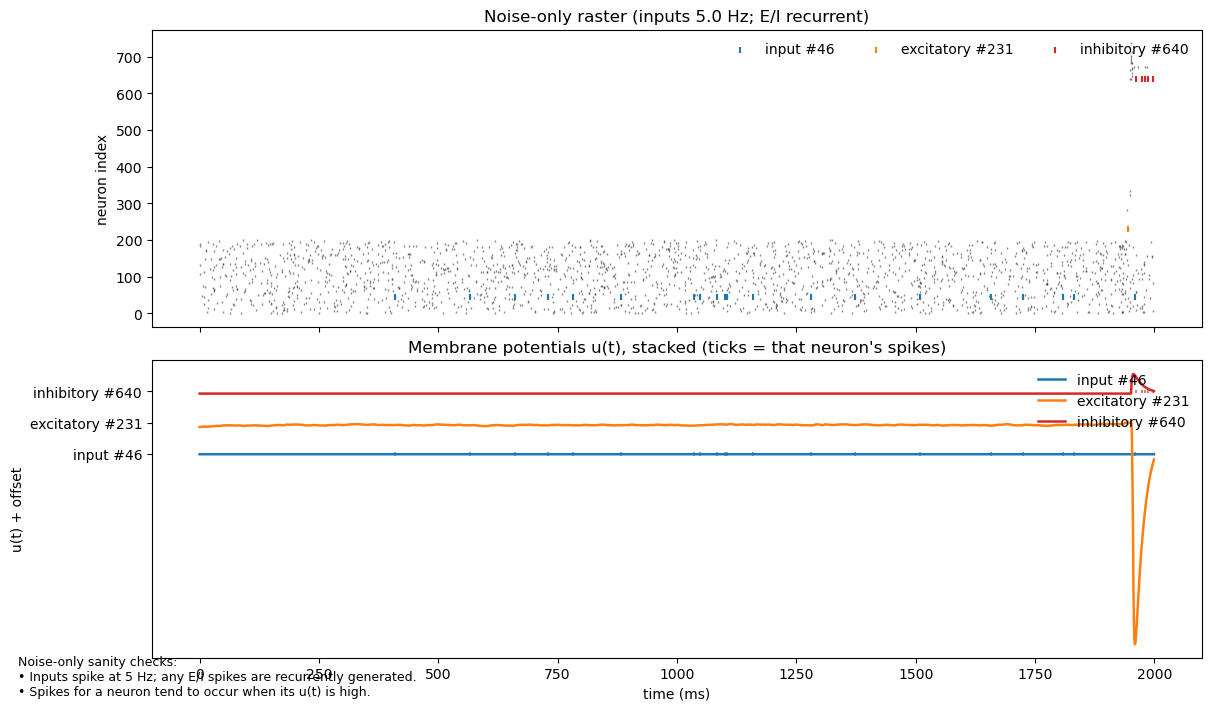

In [93]:
import numpy as np
import matplotlib.pyplot as plt

def viz_full_raster_and_traces(net,
                               duration_ms=2000,      # 2 seconds
                               seed=1,
                               bg_rate_hz=5.0,        # inputs' noise rate during noise-only
                               r_max=200.0,           # safety cap for recurrent rates (Hz)
                               min_spikes=2):
    """
    Noise-only phase:
      • Inputs: Poisson(bg_rate_hz).
      • Exc/Inh: recurrent Poisson from r(t)=r0*exp(0.25*u), with absolute refractory.
    Plots:
      (top)  Full spike raster (all neurons), three exemplars highlighted (1 input / 1 exc / 1 inh).
      (bot)  Membrane potentials u(t) for those three neurons, stacked; their own spikes shown as ticks.
    """
    rng = np.random.default_rng(seed)
    dt = float(net.dt)
    T  = int(round(duration_ms / dt))
    N  = net.N

    # reset state and recurrent rates
    net.reset_state()
    rates_dyn = np.zeros(N, float)
    rates_dyn[net.is_exc | net.is_inh] = net.r0  # start near baseline
    lam_inp = bg_rate_hz * (dt / 1000.0)

    # logs
    S = np.zeros((N, T), dtype=int)   # spikes
    U = np.zeros((N, T), dtype=float) # membrane drive u
    R = np.zeros((N, T), dtype=float) # instantaneous rate

    EI = (net.is_exc | net.is_inh)

    for t in range(T):
        spikes = np.zeros(N, dtype=int)z

        # inputs: noise-only background
        spikes[net.is_inp] = rng.poisson(lam_inp, size=net.is_inp.sum())

        # E/I: recurrent Poisson (clipped) + refractory
        lam_ei = np.clip(rates_dyn[EI], 0.0, r_max) * (dt / 1000.0)
        spikes[EI] = rng.poisson(lam_ei)
        spikes = net.apply_refractory_and_update(spikes)

        out = net.step(spikes)
        S[:, t] = spikes
        U[:, t] = out["u"]
        R[:, t] = out["r"]

        # update recurrent rates for next step (inputs remain externally driven only)
        rates_dyn[EI] = np.clip(out["r"][EI], 0.0, r_max)
        rates_dyn[net.is_inp] = 0.0

    # pick exemplars (most spikes) for input, exc, inh
    def pick(mask):
        idx = np.flatnonzero(mask)
        if idx.size == 0: return None
        counts = S[idx].sum(axis=1)
        j = int(idx[np.argmax(counts)])
        return j if counts.max() >= min_spikes else j

    j_inp = pick(net.is_inp)
    j_exc = pick(net.is_exc)
    j_inh = pick(net.is_inh)
    exemplars = [(j_inp, 'C0', 'input'), (j_exc, 'C1', 'excitatory'), (j_inh, 'C3', 'inhibitory')]
    exemplars = [(j,c,lbl) for (j,c,lbl) in exemplars if j is not None]

    # plotting
    t_ms = np.arange(T) * dt
    fig, axes = plt.subplots(2, 1, figsize=(12, 7), sharex=True, constrained_layout=True)

    # (1) full raster
    ax = axes[0]
    n_idx, t_idx = np.nonzero(S > 0)
    reps = S[n_idx, t_idx].astype(int)
    rep_idx = np.repeat(np.arange(n_idx.size), reps)  # handle counts>1 per bin
    ax.scatter(t_idx[rep_idx] * dt, n_idx[rep_idx], s=2, marker='|', color='0.2', alpha=0.6, linewidths=1)

    for (j, c, lbl) in exemplars:
        tj = np.repeat(np.arange(T), S[j])
        ax.scatter(tj * dt, np.full_like(tj, j), s=18, marker='|', color=c, label=f"{lbl} #{j}")

    ax.set_title(f"Noise-only raster (inputs {bg_rate_hz:.1f} Hz; E/I recurrent)")
    ax.set_ylabel("neuron index")
    if exemplars:
        ax.legend(frameon=False, loc='upper right', ncol=3)

    # (2) stacked membrane potentials with spike ticks
    ax = axes[1]
    if exemplars:
        amps = [np.ptp(U[j]) + 1e-9 for (j,_,_) in exemplars]
        gap  = np.median(amps) * 1.6
        offsets = np.arange(len(exemplars)) * gap

        for k, (j, c, lbl) in enumerate(exemplars):
            y = U[j] + offsets[k]
            ax.plot(t_ms, y, color=c, lw=1.8, label=f"{lbl} #{j}")
            sj = np.where(S[j] > 0)[0]
            if sj.size:
                ax.vlines(sj * dt, offsets[k]-0.06*gap, offsets[k]+0.06*gap, colors=c, alpha=0.7, linewidth=1.3)

        ax.set_yticks(offsets)
        ax.set_yticklabels([f"{lbl} #{j}" for (j,_,lbl), _off in zip(exemplars, offsets)])
    ax.set_title("Membrane potentials u(t), stacked (ticks = that neuron's spikes)")
    ax.set_xlabel("time (ms)")
    ax.set_ylabel("u(t) + offset")
    ax.legend(frameon=False, loc='upper right')

    fig.text(
        0.01, 0.01,
        "Noise-only sanity checks:\n"
        "• Inputs spike at 5 Hz; any E/I spikes are recurrently generated.\n"
        "• Spikes for a neuron tend to occur when its u(t) is high.",
        fontsize=9, va='bottom'
    )
    plt.show()
viz_full_raster_and_traces(net)  # defaults to 2s, inputs at 5 Hz


In [94]:
# 1) Baseline (no spikes) — should approximate excitability bias
net.reset_state()
out0 = net.step(np.zeros(net.N, int))
print("u baseline: mean/median (exc) =", out0["u"][net.is_exc].mean(), np.median(out0["u"][net.is_exc]))
print("u baseline: mean/median (inh) =", out0["u"][net.is_inh].mean(), np.median(out0["u"][net.is_inh]))
# If around -280 (E) and -140 (I): rates will be ~0.

# 2) Input drive per ms — does u budge?
import numpy as np
rng = np.random.default_rng(0)
def step_inp_noise(T=2000, rate_hz=5.0):
    net.reset_state()
    lam = rate_hz * (net.dt/1000.0)
    Ue=[]
    for _ in range(T):
        spikes = np.zeros(net.N, int)
        spikes[net.is_inp] = rng.poisson(lam, size=net.is_inp.sum())
        out = net.step(spikes)
        Ue.append(np.median(out["u"][net.is_exc]))
    return np.array(Ue)
Ue = step_inp_noise()
print("Median u_exc over noise-only:", np.percentile(Ue,[5,50,95]))
# If this stays near the baseline (very negative), PSP gain is too small.

# 3) Sanity on signs/masks
print("Any negative input->E weights?", np.any(net.W[net.is_inp[:,None] & net.is_exc[None,:]] < 0))
print("Any input->I edges?", np.any(net.C[net.is_inp[:,None] & net.is_inh[None,:]]))  # should be False


u baseline: mean/median (exc) = -285.44684306721734 -285.95601901805685
u baseline: mean/median (inh) = -135.9885837369326 -136.63179126781273
Median u_exc over noise-only: [-181.7895675  -146.33558641 -107.40415561]
Any negative input->E weights? False
Any input->I edges? False


C:\Users\miles\AppData\Local\Temp\ipykernel_23960\2884349397.py:139: RuntimeWarning: overflow encountered in exp
  r = self.r0 * np.exp(0.25 * u)
C:\Users\miles\AppData\Local\Temp\ipykernel_23960\2884349397.py:139: RuntimeWarning: overflow encountered in multiply
  r = self.r0 * np.exp(0.25 * u)


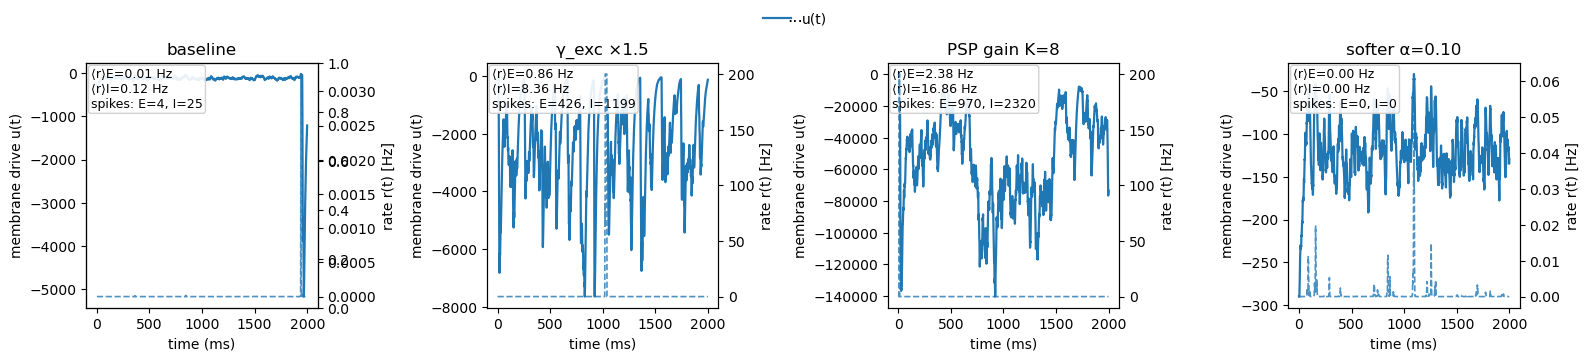

In [99]:
# === One-cell knob sweeper: visualize u(t) with overlaid r(t) for one example excitatory neuron ===
import numpy as np, matplotlib.pyplot as plt, copy

def _rebuild_synapses(vnet, K):
    """Rebuild pathway engines with a different PSP gain K (weights, delays, masks unchanged)."""
    from math import isfinite
    # Access your renamed engine class
    DelayedDoubleExpSynapses = type(vnet.engines["exc"])
    W_inp = np.where(vnet.is_inp[:,None], np.abs(vnet.W), 0.0)
    W_exc = np.where(vnet.is_exc[:,None], np.abs(vnet.W), 0.0)
    W_inh = np.where(vnet.is_inh[:,None], np.abs(vnet.W), 0.0)
    vnet._syn_inp = DelayedDoubleExpSynapses(W_inp, vnet.delays, vnet.dt, K=K, 
                                             t_rise_ms=-vnet.dt/np.log(vnet.engines["exc"].alpha_r),
                                             t_fall_ms=-vnet.dt/np.log(vnet.engines["exc"].alpha_f),
                                             C=vnet.C)
    vnet._syn_exc = DelayedDoubleExpSynapses(W_exc, vnet.delays, vnet.dt, K=K, 
                                             t_rise_ms=-vnet.dt/np.log(vnet.engines["exc"].alpha_r),
                                             t_fall_ms=-vnet.dt/np.log(vnet.engines["exc"].alpha_f),
                                             C=vnet.C)
    vnet._syn_inh = DelayedDoubleExpSynapses(W_inh, vnet.delays, vnet.dt, K=K, 
                                             t_rise_ms=-vnet.dt/np.log(vnet.engines["exc"].alpha_r),
                                             t_fall_ms=-vnet.dt/np.log(vnet.engines["exc"].alpha_f),
                                             C=vnet.C)
    vnet.reset_state()

def _make_variant(base_net, name, gamma_exc, K, alpha):
    """Deep-copy base net, tweak gamma/K, and return variant with metadata."""
    v = copy.deepcopy(base_net)
    v.gamma_exc = float(gamma_exc)
    v.E_generic_exc = 300.0 * v.gamma_exc  # update generic excitability
    _rebuild_synapses(v, K=float(K))       # rebuild engines with new PSP gain
    return {"name": name, "net": v, "alpha": float(alpha)}

def _pick_example_exc(net):
    """Choose a stable example excitatory neuron: max incoming |W| from inputs."""
    exc_idx = np.flatnonzero(net.is_exc)
    if exc_idx.size == 0: return None
    W_ie = np.abs(net.W[net.is_inp][:, net.is_exc])  # (N_inp, N_exc)
    j_rel = int(np.argmax(W_ie.sum(axis=0)))
    return int(exc_idx[j_rel])

def sweep_knobs_and_plot(base_net,
                         duration_ms=2000, bg_rate_hz=5.0, r_max=200.0, seed=0):
    """
    Runs a noise-only phase (inputs @ bg_rate_hz) for several knob variants:
      - gamma_exc (generic excitability scale)
      - K (PSP gain)
      - alpha (slope in r = r0 * exp(alpha * u))  [used for spike generation and overlay]
    Shows u(t) with r(t) overlay for one example excitatory neuron in each variant.
    """
    rng = np.random.default_rng(seed)
    dt = float(base_net.dt)
    T  = int(round(duration_ms / dt))
    N  = base_net.N
    EI = (base_net.is_exc | base_net.is_inh)

    # Variants to try (tune as you like)
    variants = [
        _make_variant(base_net, "baseline",        gamma_exc=1.0, K=1.0,  alpha=0.25),
        _make_variant(base_net, "γ_exc ×1.5",      gamma_exc=1.5, K=1.0,  alpha=0.25),
        _make_variant(base_net, "PSP gain K=8",    gamma_exc=1.0, K=8.0,  alpha=0.25),
        _make_variant(base_net, "softer α=0.10",   gamma_exc=1.0, K=1.0,  alpha=0.10),
    ]

    # Use the SAME example excit neuron across all variants for comparability
    j_star = _pick_example_exc(base_net)
    if j_star is None:
        raise RuntimeError("No excitatory neuron found to visualize.")

    # Simulate each variant
    results = []
    for v in variants:
        net = v["net"]; alpha = v["alpha"]
        net.reset_state()
        rates_prev = np.zeros(N); rates_prev[EI] = net.r0  # start near baseline for E/I
        lam_inp = bg_rate_hz * (dt / 1000.0)

        u_star = np.zeros(T); r_star = np.zeros(T)
        E_mean = np.zeros(T); I_mean = np.zeros(T)
        E_spk = 0; I_spk = 0

        for t in range(T):
            spikes = np.zeros(N, dtype=int)
            # inputs: noise-only
            spikes[net.is_inp] = rng.poisson(lam_inp, size=net.is_inp.sum())
            # E/I: recurrent Poisson with refractory, using alpha for mapping
            lam_ei = np.clip(rates_prev[EI], 0.0, r_max) * (dt / 1000.0)
            spikes[EI] = rng.poisson(lam_ei)
            spikes = net.apply_refractory_and_update(spikes)

            out = net.step(spikes)
            u = out["u"]  # we compute our own r_next with chosen alpha
            r_cap_local = 200.0                      # or tie to a function arg
            phi = np.clip(alpha * u, -50.0, np.log(r_cap_local / net.r0))
            r_next = net.r0 * np.exp(phi)

            # logs
            u_star[t] = u[j_star]
            r_star[t] = r_next[j_star]
            E_mean[t] = r_next[net.is_exc].mean() if net.is_exc.any() else 0.0
            I_mean[t] = r_next[net.is_inh].mean() if net.is_inh.any() else 0.0
            E_spk += spikes[net.is_exc].sum()
            I_spk += spikes[net.is_inh].sum()

            # prepare for next step
            rates_prev[:] = 0.0
            rates_prev[EI] = r_next[EI]  # only E/I are recurrent; inputs stay externally driven

        results.append({"name": v["name"], "u": u_star, "r": r_star,
                        "E_mean": E_mean.mean(), "I_mean": I_mean.mean(),
                        "E_spk": E_spk, "I_spk": I_spk})

    # --- Plot: one panel per variant; u(t) with r(t) overlay (twin y-axis) ---
    t_ms = np.arange(T) * dt
    ncol = len(results)
    fig, axes = plt.subplots(1, ncol, figsize=(4*ncol, 3.6), sharey=False)

    if ncol == 1:
        axes = [axes]

    for ax, res in zip(axes, results):
        ax.plot(t_ms, res["u"], lw=1.6, label="u(t)")
        ax.set_title(res["name"])
        ax.set_xlabel("time (ms)")
        ax.set_ylabel("membrane drive u(t)")
        ax2 = ax.twinx()
        ax2.plot(t_ms, res["r"], lw=1.2, alpha=0.8, label="r(t)", linestyle="--")
        ax2.set_ylabel("rate r(t) [Hz]")
        # small caption inside each panel
        ax.text(0.02, 0.98,
                f"⟨r⟩E={res['E_mean']:.2f} Hz\n⟨r⟩I={res['I_mean']:.2f} Hz\n"
                f"spikes: E={res['E_spk']}, I={res['I_spk']}",
                transform=ax.transAxes, va="top", fontsize=9,
                bbox=dict(boxstyle="round,pad=0.2", fc="white", ec="0.8", alpha=0.9))

    # one combined legend
    lines, labels = axes[0].get_legend_handles_labels()
    lines2, labels2 = axes[0].twinx().get_legend_handles_labels()
    fig.legend(lines + lines2, labels + labels2, loc="upper center", ncol=4, frameon=False)
    plt.tight_layout(rect=[0, 0, 1, 0.94])   # leave room for suptitle
    fig.suptitle(f"...", y=0.99)
    plt.show()

# --- Run it on your existing network object 'net' (noise-only, 2 s) ---
sweep_knobs_and_plot(net, duration_ms=2000, bg_rate_hz=5.0, r_max=200.0, seed=1)


C:\Users\miles\AppData\Local\Temp\ipykernel_23960\2884349397.py:139: RuntimeWarning: overflow encountered in exp
  r = self.r0 * np.exp(0.25 * u)
C:\Users\miles\AppData\Local\Temp\ipykernel_23960\2884349397.py:139: RuntimeWarning: overflow encountered in multiply
  r = self.r0 * np.exp(0.25 * u)


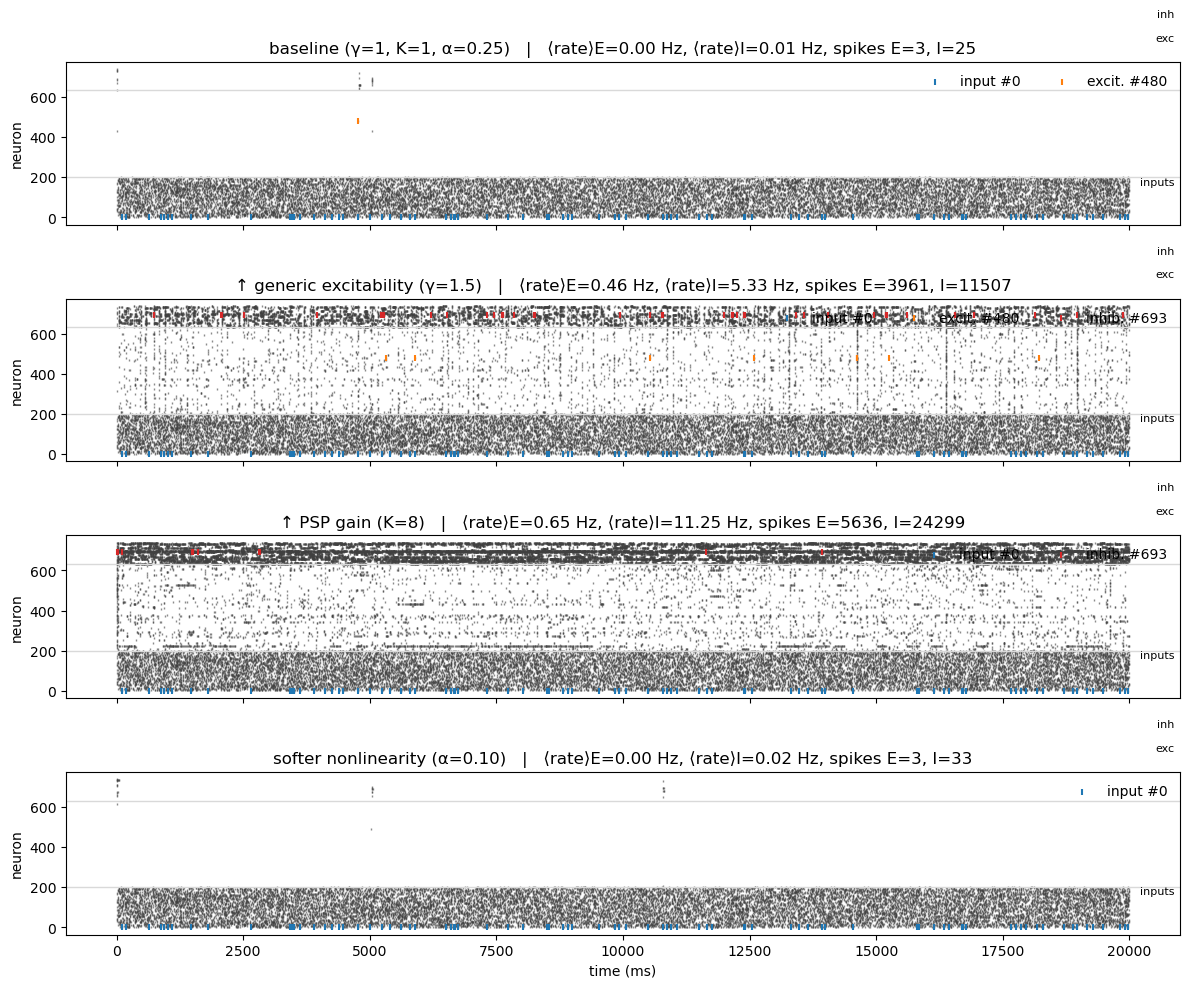

In [107]:
# ==== Raster sweeper: 4 stacked rasters (noise-only) for different knob settings ====
import numpy as np, matplotlib.pyplot as plt, copy

def _rebuild_synapses(vnet, K):
    """Rebuild synapse engines using the same W/C/delays but a new PSP gain K."""
    Syn = type(vnet.engines["exc"])
    # recover taus from existing engine (shared across pathways)
    ar = vnet.engines["exc"].alpha_r
    af = vnet.engines["exc"].alpha_f
    t_rise_ms = -vnet.dt / np.log(ar)
    t_fall_ms = -vnet.dt / np.log(af)
    # split weights by pathway (magnitudes only; sign handled in u = y+z-h)
    W_inp = np.where(vnet.is_inp[:,None], np.abs(vnet.W), 0.0)
    W_exc = np.where(vnet.is_exc[:,None], np.abs(vnet.W), 0.0)
    W_inh = np.where(vnet.is_inh[:,None], np.abs(vnet.W), 0.0)
    vnet._syn_inp = Syn(W_inp, vnet.delays, vnet.dt, t_rise_ms, t_fall_ms, K, vnet.C)
    vnet._syn_exc = Syn(W_exc, vnet.delays, vnet.dt, t_rise_ms, t_fall_ms, K, vnet.C)
    vnet._syn_inh = Syn(W_inh, vnet.delays, vnet.dt, t_rise_ms, t_fall_ms, K, vnet.C)
    vnet.reset_state()

def _make_variant(base_net, name, gamma_exc, K, alpha):
    """Deep-copy base net; adjust γ_exc (generic excitability), PSP gain K, and α for r = r0*exp(αu)."""
    v = copy.deepcopy(base_net)
    v.gamma_exc = float(gamma_exc)
    v.E_generic_exc = 300.0 * v.gamma_exc
    v.alpha = float(alpha) if hasattr(v, "alpha") else float(alpha)  # tolerated if you didn’t add .alpha
    _rebuild_synapses(v, K=float(K))
    return {"name": name, "net": v}

def _pick_exemplars(net, S_all=None):
    """Pick one input, one excit, one inh neuron to highlight (most input degree / activity)."""
    j_inp = int(np.flatnonzero(net.is_inp)[0]) if net.is_inp.any() else None
    # excitatory exemplar: the E with largest total |W| from inputs
    exc_idx = np.flatnonzero(net.is_exc)
    if exc_idx.size:
        W_ie = np.abs(net.W[net.is_inp][:, net.is_exc])
        j_exc = int(exc_idx[np.argmax(W_ie.sum(axis=0))])
    else:
        j_exc = None
    # inhibitory exemplar: largest |W| from E
    inh_idx = np.flatnonzero(net.is_inh)
    if inh_idx.size:
        W_ie2 = np.abs(net.W[net.is_exc][:, net.is_inh])
        j_inh = int(inh_idx[np.argmax(W_ie2.sum(axis=0))])
    else:
        j_inh = None
    return [(j_inp,'C0','input'), (j_exc,'C1','excit.'), (j_inh,'C3','inhib.')]

def sweep_rasters(net_base, duration_ms=2000, bg_rate_hz=5.0, r_cap=200.0, seed=1):
    """
    Runs 2 s noise-only for four knob settings and plots 4 stacked rasters (shared time axis).
    Knobs (edit below in `variants`):
      • baseline
      • γ_exc ×1.5 (generic excitability higher)
      • PSP gain K=8
      • softer nonlinearity α=0.10
    """
    rng = np.random.default_rng(seed)
    dt = float(net_base.dt)
    T  = int(round(duration_ms / dt))
    N  = net_base.N
    EI = (net_base.is_exc | net_base.is_inh)

    # Define variants
    variants = [
        _make_variant(net_base, "baseline (γ=1, K=1, α=0.25)", gamma_exc=1.0, K=1.0,  alpha=0.25),
        _make_variant(net_base, "↑ generic excitability (γ=1.5)", gamma_exc=1.5, K=1.0,  alpha=0.25),
        _make_variant(net_base, "↑ PSP gain (K=8)",               gamma_exc=1.0, K=8.0,  alpha=0.25),
        _make_variant(net_base, "softer nonlinearity (α=0.10)",   gamma_exc=1.0, K=1.0,  alpha=0.10),
    ]

    # Pre-generate the SAME input spikes for all variants (noise-only at 5 Hz)
    lam_inp = bg_rate_hz * (dt / 1000.0)
    S_inp = rng.poisson(lam_inp, size=(net_base.is_inp.sum(), T))  # (N_inp, T)
    inp_idx = np.flatnonzero(net_base.is_inp)

    # Choose exemplars once (same indices shown across panels)
    exemplars = _pick_exemplars(net_base)

    # Sim & collect spike rasters
    rasters = []
    stats = []
    for v in variants:
        net = v["net"]
        net.reset_state()
        rates_prev = np.zeros(N, float)
        rates_prev[EI] = net.r0  # start near baseline for recurrent neurons

        S_all = np.zeros((N, T), dtype=int)

        for t in range(T):
            spikes = np.zeros(N, dtype=int)
            # inputs: reuse same noise-only draws
            spikes[inp_idx] = S_inp[:, t]

            # E/I: recurrent Poisson from last rates with refractory; safe mapping r = r0*exp(αu) with cap
            lam_ei = np.clip(rates_prev[EI], 0.0, r_cap) * (dt / 1000.0)
            spikes[EI] = rng.poisson(lam_ei)
            spikes = net.apply_refractory_and_update(spikes)

            out = net.step(spikes)
            u = out["u"]
            # compute next-step recurrent rates with the variant's α; clamp to r_cap
            alpha = getattr(net, "alpha", 0.25)
            phi = np.clip(alpha * u, -50.0, np.log(r_cap / net.r0))
            r_next = net.r0 * np.exp(phi)
            rates_prev[:] = 0.0
            rates_prev[EI] = r_next[EI]  # inputs stay externally driven only

            S_all[:, t] = spikes

        rasters.append((v["name"], S_all))
        stats.append({
            "E_spk": int(S_all[net.is_exc].sum()),
            "I_spk": int(S_all[net.is_inh].sum()),
            "E_rate_mean": S_all[net.is_exc].sum() / (net.is_exc.sum() * (duration_ms/1000.0) + 1e-9),
            "I_rate_mean": S_all[net.is_inh].sum() / (net.is_inh.sum() * (duration_ms/1000.0) + 1e-9),
        })

    # ---- Plot 4 stacked rasters ----
    t_ms = np.arange(T) * dt
    fig, axes = plt.subplots(len(rasters), 1, figsize=(12, 10), sharex=True)
    if len(rasters) == 1: axes = [axes]

    # boundaries
    b_inp  = net_base.N_inp
    b_exc  = net_base.N_inp + net_base.N_exc

    for ax, ((name, S_all), stat) in zip(axes, zip(rasters, stats)):
        # base raster points
        n_idx, t_idx = np.nonzero(S_all > 0)
        reps = S_all[n_idx, t_idx].astype(int)
        rep_idx = np.repeat(np.arange(n_idx.size), reps)  # expand for counts>1
        ax.scatter(t_idx[rep_idx] * dt, n_idx[rep_idx], s=2, marker='|', color='0.25', alpha=0.6, linewidths=1)

        # highlight exemplars consistently across panels
        for (j, c, lbl) in exemplars:
            if j is None: continue
            tj = np.repeat(np.arange(T), S_all[j])
            if tj.size:
                ax.scatter(tj * dt, np.full_like(tj, j), s=16, marker='|', color=c, label=f"{lbl} #{j}")

        # population separators
        ax.axhline(b_inp-0.5, color='0.85', lw=1)
        ax.axhline(b_exc-0.5, color='0.85', lw=1)
        ax.text(0.995, (b_inp-5)/net_base.N, "inputs", transform=ax.transAxes, ha='right', va='center', fontsize=8)
        ax.text(0.995, (b_exc + net_base.N_exc/2)/net_base.N, "exc", transform=ax.transAxes, ha='right', va='center', fontsize=8)
        ax.text(0.995, (b_exc + net_base.N_inh + net_base.N_exc/2)/net_base.N, "inh", transform=ax.transAxes, ha='right', va='center', fontsize=8)

        ax.set_ylabel("neuron")
        ax.set_title(f"{name}   |   ⟨rate⟩E={stat['E_rate_mean']:.2f} Hz, ⟨rate⟩I={stat['I_rate_mean']:.2f} Hz, "
                     f"spikes E={stat['E_spk']}, I={stat['I_spk']}")

        # tidy legend
        handles, labels = ax.get_legend_handles_labels()
        if handles:
            ax.legend(handles, labels, frameon=False, loc='upper right', ncol=3)

    axes[-1].set_xlabel("time (ms)")
    plt.tight_layout()
    plt.show()

# ---- Run on your existing 'net' object (2 s, inputs 5 Hz) ----
sweep_rasters(net, duration_ms=20000, bg_rate_hz=5.0, r_cap=200.0, seed=1)


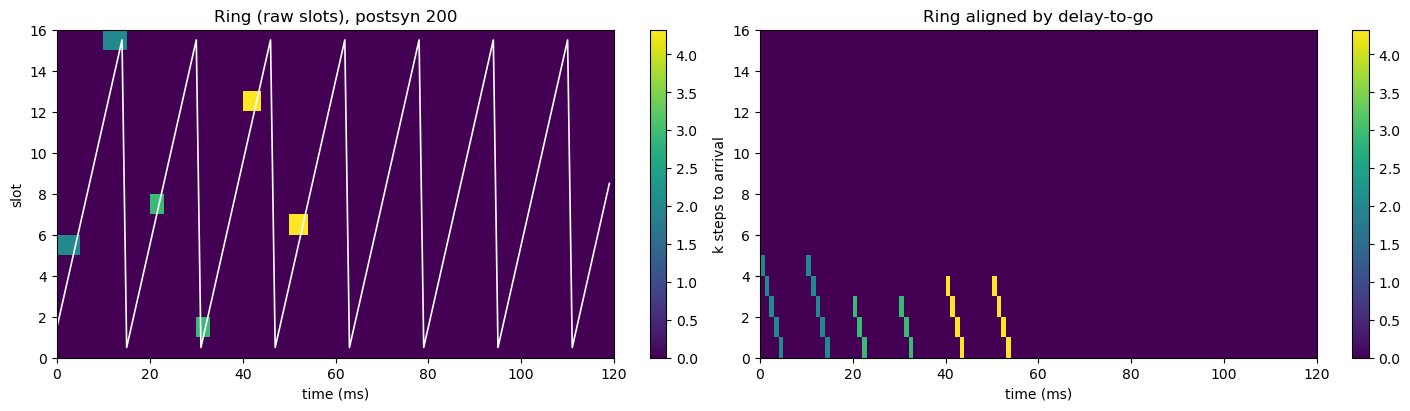

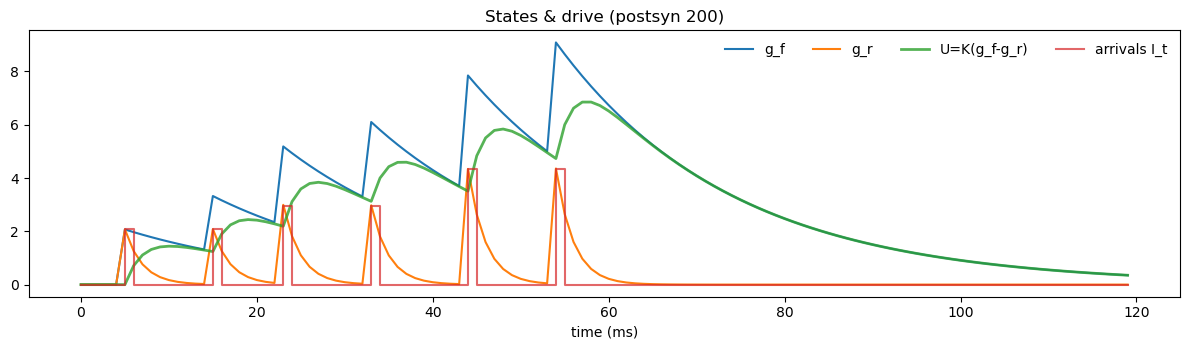

In [96]:
def viz_ring_buffer(net, T_demo=120, thr_ms=5.0, seed=1):
    rng = np.random.default_rng(seed)
    eng = net.engines["exc"]  # visualize excitatory pathway arrivals
    net.reset_state()
    # choose postsyn with ≥1 incoming delay > thr_ms
    cols_long = np.where(((eng.W != 0) & (net.delays > thr_ms)).any(axis=0))[0]
    i_sel = int(cols_long[0]) if cols_long.size else int(np.argmax((eng.W != 0).sum(axis=0)))
    # choose up to 3 presyn sources
    cand = np.where(eng.W[:, i_sel] != 0)[0]
    if cand.size == 0: 
        print("No incoming edges to visualize."); return
    # ensure at least one long-delay source
    long = cand[net.delays[cand, i_sel] > thr_ms]
    chosen = [int(long[0])] if long.size else [int(cand[np.argmax(net.delays[cand, i_sel])])]
    for j in cand:
        if j not in chosen and len(chosen) < 3:
            chosen.append(int(j))
    # build spikes: two spikes per chosen presyn
    spikes = np.zeros((eng.N_pre, T_demo), int)
    for j, t0 in zip(chosen, [0, 20, 40]):
        spikes[j, t0] = 1; spikes[j, t0+10] = 1

    # log internals over time
    arr_raw = np.zeros((eng.L, T_demo)); arr_align = np.zeros((eng.L, T_demo))
    gf = np.zeros(T_demo); gr = np.zeros(T_demo); U = np.zeros(T_demo); I_now = np.zeros(T_demo); p_hist = np.zeros(T_demo, int)
    for t in range(T_demo):
        gf_prev = eng._gf.copy(); p_prev = eng._p
        u = eng.step(spikes[:, t]); U[t] = u[i_sel]
        p_now = eng._p
        snap = eng.snapshot()
        arr_raw[:, t] = snap["inc_f"][:, i_sel]
        for k in range(eng.L): arr_align[k, t] = snap["inc_f"][(p_now + k) % eng.L, i_sel]
        gf[t], gr[t] = snap["gf"][i_sel], snap["gr"][i_sel]
        I_now[t] = gf[t] - eng.alpha_f * gf_prev[i_sel]
        p_hist[t] = p_now

    # plots
    t_ms = np.arange(T_demo) * net.dt
    fig, axes = plt.subplots(1, 2, figsize=(14, 4), constrained_layout=True)
    im0 = axes[0].imshow(arr_raw, aspect='auto', origin='lower', extent=[0, T_demo*net.dt, 0, eng.L])
    axes[0].plot(t_ms, p_hist + 0.5, color='white', lw=1.2)
    axes[0].set_title(f"Ring (raw slots), postsyn {i_sel}"); axes[0].set_xlabel("time (ms)"); axes[0].set_ylabel("slot")
    fig.colorbar(im0, ax=axes[0], fraction=0.046, pad=0.04)

    im1 = axes[1].imshow(arr_align, aspect='auto', origin='lower', extent=[0, T_demo*net.dt, 0, eng.L])
    axes[1].set_title("Ring aligned by delay-to-go"); axes[1].set_xlabel("time (ms)"); axes[1].set_ylabel("k steps to arrival")
    fig.colorbar(im1, ax=axes[1], fraction=0.046, pad=0.04)
    plt.show()

    plt.figure(figsize=(12, 3.6))
    plt.plot(t_ms, gf, label="g_f"); plt.plot(t_ms, gr, label="g_r")
    plt.plot(t_ms, U, label="U=K(g_f-g_r)", lw=2, alpha=0.8)
    plt.step(t_ms, I_now, where='post', label="arrivals I_t", alpha=0.7)
    plt.legend(ncol=4, frameon=False); plt.xlabel("time (ms)"); plt.title(f"States & drive (postsyn {i_sel})"); plt.tight_layout(); plt.show()

viz_ring_buffer(net)


C:\Users\miles\AppData\Local\Temp\ipykernel_23960\871696237.py:156: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


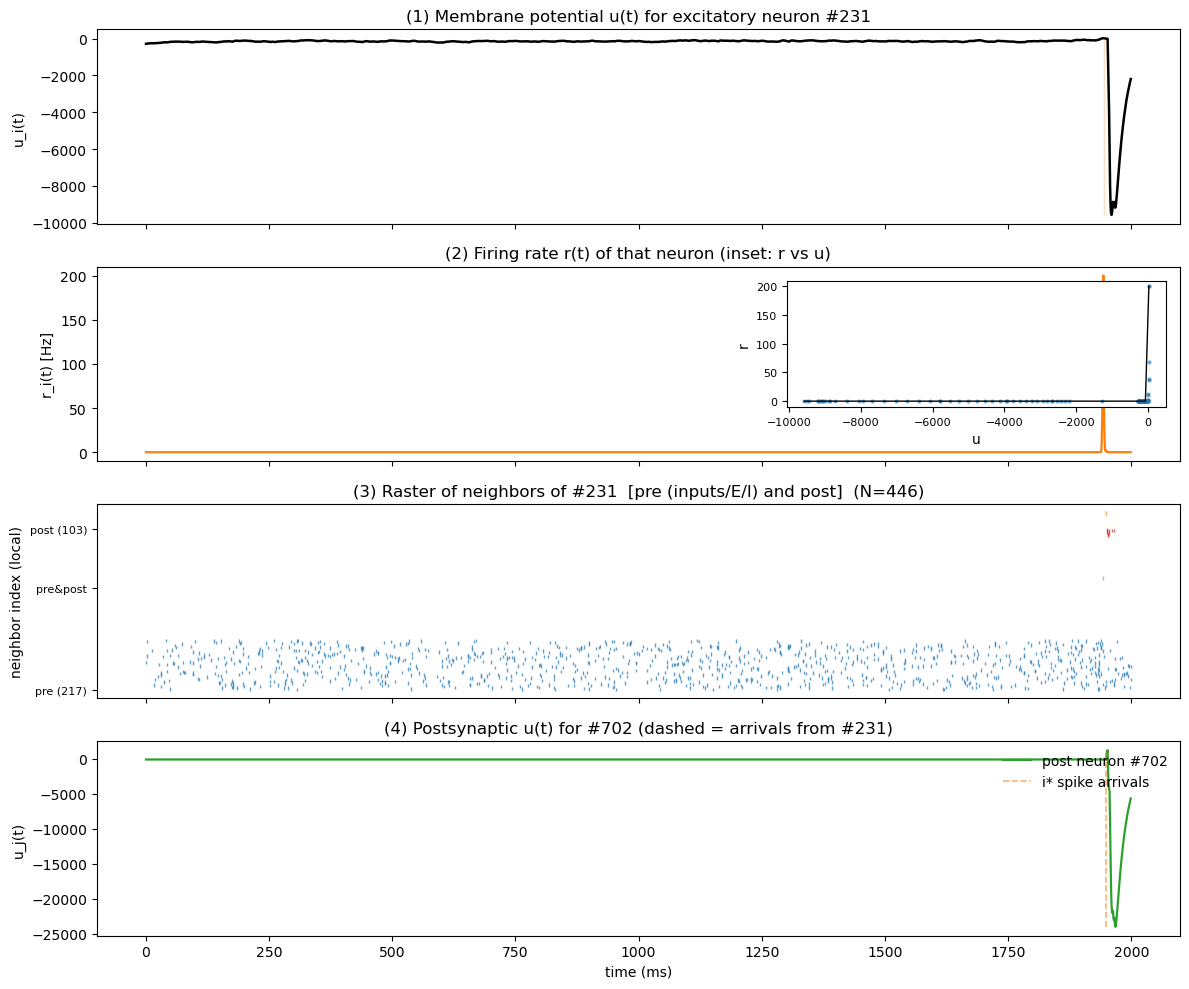

In [105]:
import numpy as np
import matplotlib.pyplot as plt

def viz_focus_excit_neuron(net, duration_ms=2000, bg_rate_hz=5.0, r_cap=200.0, seed=1):
    """
    Runs a 2s noise-only phase (inputs @ bg_rate_hz), then plots 4 vertically stacked panels:
      (1) u_i(t) for a spiking excitatory neuron i (auto-chosen).
      (2) r_i(t) with a small inset r vs u.
      (3) Raster of all neurons connected to i (pre & post).
      (4) u_j(t) for one postsynaptic partner j of i, with vertical lines at i's spike arrivals (t + delay).
    All panels share the time axis.
    """
    rng = np.random.default_rng(seed)
    dt = float(net.dt)
    T  = int(round(duration_ms / dt))
    N  = net.N
    EI_mask = (net.is_exc | net.is_inh)

    # --- simulate noise-only (inputs at 5 Hz), E/I recurrent with refractory ---
    net.reset_state()
    S = np.zeros((N, T), dtype=int)
    U = np.zeros((N, T), dtype=float)
    R = np.zeros((N, T), dtype=float)

    rates_prev = np.zeros(N, float)
    rates_prev[EI_mask] = net.r0  # start near baseline
    lam_inp = bg_rate_hz * (dt / 1000.0)
    alpha = getattr(net, "alpha", 0.25)  # slope in r = r0*exp(alpha*u)

    for t in range(T):
        spikes = np.zeros(N, dtype=int)
        # inputs: Poisson(bg_rate_hz)
        spikes[net.is_inp] = rng.poisson(lam_inp, size=net.is_inp.sum())
        # E/I: recurrent Poisson from previous rates, then refractory
        lam_ei = np.clip(rates_prev[EI_mask], 0.0, r_cap) * (dt / 1000.0)
        spikes[EI_mask] = rng.poisson(lam_ei)
        spikes = net.apply_refractory_and_update(spikes)

        out = net.step(spikes)
        u = out["u"]
        # safe rate mapping (avoid overflow and enforce r_cap)
        phi = np.clip(alpha * u, -50.0, np.log(r_cap / net.r0))
        r_next = net.r0 * np.exp(phi)

        S[:, t] = spikes
        U[:, t] = u
        R[:, t] = r_next

        rates_prev[:] = 0.0
        rates_prev[EI_mask] = r_next[EI_mask]

    # --- choose a spiking excitatory neuron i* (fallback: most active/peaky if none spiked) ---
    exc_idx = np.flatnonzero(net.is_exc)
    if exc_idx.size == 0:
        raise RuntimeError("No excitatory neurons found.")
    counts_exc = S[exc_idx].sum(axis=1)
    if counts_exc.max() > 0:
        i_star = int(exc_idx[np.argmax(counts_exc)])
    else:
        # fallback: largest peak u over time
        i_star = int(exc_idx[np.argmax(U[exc_idx].max(axis=1))])
        print("Note: no E spikes observed; showing neuron with largest u peak.")

    # --- neighbors (pre & post) and a postsynaptic partner j* ---
    pre_idx  = np.where(net.C[:, i_star])[0]         # presyn to i*
    post_idx = np.where(net.C[i_star, :])[0]         # postsyn from i*
    neighbors = np.unique(np.concatenate([pre_idx, post_idx])) if (pre_idx.size+post_idx.size)>0 else np.array([], int)

    # pick a postsynaptic partner j* (largest weight from i*, if any)
    j_star = None
    if post_idx.size:
        row = net.W[i_star, post_idx]
        if row.size:
            j_star = int(post_idx[np.argmax(np.abs(row))])

    t_ms = np.arange(T) * dt

    # --- plotting: 4 vertical panels, shared x-axis ---
    fig, axes = plt.subplots(4, 1, figsize=(12, 10), sharex=True)

    # (1) u_i(t) with its spikes
    ax = axes[0]
    ax.plot(t_ms, U[i_star], color='k', lw=1.8)
    t_spk_i = np.where(S[i_star] > 0)[0]
    if t_spk_i.size:
        ax.vlines(t_spk_i * dt, ymin=np.min(U[i_star]), ymax=np.max(U[i_star]), colors='C1', alpha=0.25, lw=1)
    ax.set_title(f"(1) Membrane potential u(t) for excitatory neuron #{i_star}")
    ax.set_ylabel("u_i(t)")

    # (2) r_i(t) with inset r vs u
    ax = axes[1]
    ax.plot(t_ms, R[i_star], color='C1', lw=1.6)
    ax.set_title("(2) Firing rate r(t) of that neuron (inset: r vs u)")
    ax.set_ylabel("r_i(t) [Hz]")

    # inset: r vs u scatter
    from mpl_toolkits.axes_grid1.inset_locator import inset_axes
    axins = inset_axes(ax, width="35%", height="65%", loc="upper right", borderpad=1)
    axins.scatter(U[i_star], R[i_star], s=4, alpha=0.5)
    # overlay ideal curve for the span of u
    u_span = np.linspace(np.min(U[i_star]), np.max(U[i_star]), 100)
    phi_span = np.clip(alpha * u_span, -50.0, np.log(r_cap / net.r0))
    axins.plot(u_span, net.r0 * np.exp(phi_span), color='k', lw=1)
    axins.set_xlabel("u"); axins.set_ylabel("r"); axins.tick_params(labelsize=8)

    # (3) raster of neighbors (pre & post). Color by type; highlight pre vs post sets.
    ax = axes[2]
    if neighbors.size:
        # local ordering: pres first, then posts-only (exclude duplicates)
        pres_only = np.setdiff1d(pre_idx, post_idx, assume_unique=False)
        both      = np.intersect1d(pre_idx, post_idx)
        posts_only= np.setdiff1d(post_idx, pre_idx, assume_unique=False)
        ordered   = np.concatenate([pres_only, both, posts_only])
        ymap = {n:i for i,n in enumerate(ordered)}
        # scatter spikes
        n_idx, t_idx = np.nonzero(S[ordered] > 0)
        reps = S[ordered][n_idx, t_idx].astype(int)
        rep_idx = np.repeat(np.arange(n_idx.size), reps)
        # color by type
        types = np.where(net.is_inp[ordered], 'C0', np.where(net.is_exc[ordered], 'C1', 'C3'))
        colors = [types[i] for i in n_idx[rep_idx]]
        ax.scatter(t_idx[rep_idx] * dt, n_idx[rep_idx], s=6, marker='|', c=colors, alpha=0.7, linewidths=1)
        # annotate regions
        ax.set_yticks([ymap[n] for n in [*pres_only[:1], *both[:1], *posts_only[:1]] if n in ymap])
        ax.set_yticklabels([f"pre ({len(pres_only)})" if pres_only.size else "",
                            "pre&post" if both.size else "",
                            f"post ({len(posts_only)})" if posts_only.size else ""], fontsize=8)
        ax.set_title(f"(3) Raster of neighbors of #{i_star}  [pre (inputs/E/I) and post]  (N={neighbors.size})")
    else:
        ax.text(0.5, 0.5, "No connected neighbors", ha='center', va='center')
        ax.set_title("(3) Raster of neighbors (none)")
    ax.set_ylabel("neighbor index (local)")

    # (4) u_j(t) for a postsynaptic partner, with i*'s arrival times marked
    ax = axes[3]
    if j_star is not None:
        ax.plot(t_ms, U[j_star], color='C2', lw=1.6, label=f"post neuron #{j_star}")
        # predicted arrival times of i* spikes at j*
        delays_ij = net.delays[i_star, j_star]
        if delays_ij > 0 and t_spk_i.size:
            k = int(round(delays_ij / dt))
            arr_times = t_spk_i + k
            arr_times = arr_times[arr_times < T]
            if arr_times.size:
                ax.vlines(arr_times * dt, ymin=np.min(U[j_star]), ymax=np.max(U[j_star]),
                          colors='C1', linestyles='dashed', alpha=0.6, lw=1.2,
                          label="i* spike arrivals")
        ax.legend(frameon=False, loc='upper right')
        ax.set_title(f"(4) Postsynaptic u(t) for #{j_star} (dashed = arrivals from #{i_star})")
    else:
        ax.text(0.5, 0.5, "No postsynaptic partner found", ha='center', va='center')
        ax.set_title("(4) Postsynaptic u(t)")
    ax.set_xlabel("time (ms)")
    ax.set_ylabel("u_j(t)")

    plt.tight_layout()
    plt.show()

# --- Run it on your existing 'net' object ---
viz_focus_excit_neuron(net, duration_ms=2000, bg_rate_hz=5.0, r_cap=200.0, seed=1)
